<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [739]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [740]:
# Load the data
house = pd.read_csv('./housing.csv')
with open('./data_description.txt') as f:
    for line in f:
        print line

MSSubClass: Identifies the type of dwelling involved in the sale.	



        20	1-STORY 1946 & NEWER ALL STYLES

        30	1-STORY 1945 & OLDER

        40	1-STORY W/FINISHED ATTIC ALL AGES

        45	1-1/2 STORY - UNFINISHED ALL AGES

        50	1-1/2 STORY FINISHED ALL AGES

        60	2-STORY 1946 & NEWER

        70	2-STORY 1945 & OLDER

        75	2-1/2 STORY ALL AGES

        80	SPLIT OR MULTI-LEVEL

        85	SPLIT FOYER

        90	DUPLEX - ALL STYLES AND AGES

       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER

       150	1-1/2 STORY PUD - ALL AGES

       160	2-STORY PUD - 1946 & NEWER

       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER

       190	2 FAMILY CONVERSION - ALL STYLES AND AGES



MSZoning: Identifies the general zoning classification of the sale.

		

       A	Agriculture

       C	Commercial

       FV	Floating Village Residential

       I	Industrial

       RH	Residential High Density

       RL	Residential Low Density

       RP	Residential 

# Overview of dataset

In [741]:
# A:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

>There are altogether 1460 houses with 81 features which are categorized to 3 floats, 35 integers and 43 string (possibly categorical) datatypes. Some features have null values which range from as little as 1 (Electrical) to as many as 1453 (PoolQC)

>Since we will be predicting on the saleprice, let us analyze our dependent variable

## Analysis of dependent variable

In [742]:
house['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

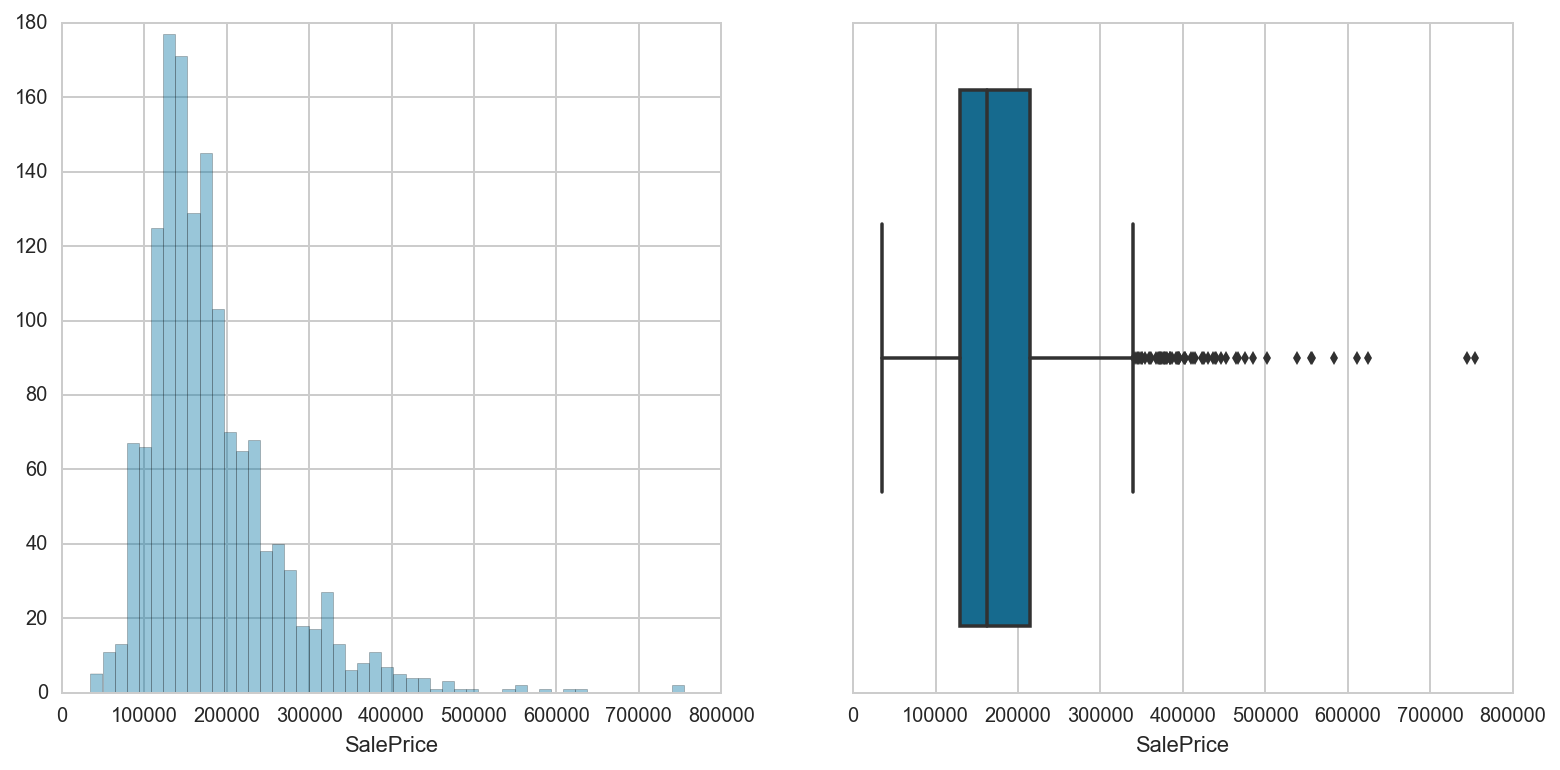

In [743]:
fig, ax = plt.subplots(1,2, figsize=(13,6))
sns.distplot(house['SalePrice'], kde=False, ax=ax[0])
sns.boxplot(house['SalePrice'], ax=ax[1])
plt.show()

>The dependent variable looks to be right skewed due to several high valued houses. The boxplot shows the presence of outliers beyond $340,000. For the purpose of linear regression, we do not have to assume that our dependent variable follows a normal distribution. But we will keep in mind that we might want to do some outlier processing to improve the regression results

# Initial cleaning of data
Before we dive deeper into the features, we will perform some preprocessing work. They include:

1. Cleaning the column headers
2. Checking for duplicates
3. Checking for negative numbers
4. Removing non-residential houses
5. Handling the null values

### Clean column headers

In [744]:
#Columns look ok except I prefer them to all be in small caps. Easier to manage
def clean_columns(df):
    df.columns = [x.lower() for x in df.columns]
    return df
clean_columns(house)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


> ID can be set as index

In [745]:
house.set_index('id', inplace=True )

### Check for duplicates

In [746]:
house.duplicated().sum()

0

### Check for negative numbers

In [747]:

house.lt(0).sum().sum()

0

### Remove non-residential housing

In [748]:
house['mszoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: mszoning, dtype: int64

Seems like there are 10 non-residential properties. We should remove them from our dataset

In [749]:
house = house.loc[house['mszoning'] != 'C (all)',:]

In [750]:
#verify 10 rows were dropped
house.shape

(1450, 80)

In [751]:
house.reset_index(drop=True, inplace=True)
house.drop('id', axis=1, inplace=)

### Handle Null values
As a rule of thumb, features with more than 70% null values should be dropped as imputing them with artificial values will not be a good representation of the actual observations. 

In this case, we will drop features that have more than **1020** null values

In [752]:
#Sort features by sum of null values
house.isnull().sum().sort_values(ascending=False)

poolqc           1443
miscfeature      1398
alley            1361
fence            1172
fireplacequ       681
lotfrontage       259
garagetype         79
garagecond         79
garagefinish       79
garagequal         79
garageyrblt        79
bsmtfintype2       38
bsmtexposure       38
bsmtqual           37
bsmtcond           37
bsmtfintype1       37
masvnrarea          8
masvnrtype          8
electrical          1
roofmatl            0
exterior1st         0
roofstyle           0
exterqual           0
exterior2nd         0
yearbuilt           0
extercond           0
foundation          0
yearremodadd        0
saleprice           0
overallcond         0
                 ... 
garagearea          0
paveddrive          0
wooddecksf          0
openporchsf         0
3ssnporch           0
bsmtunfsf           0
screenporch         0
poolarea            0
miscval             0
mosold              0
yrsold              0
saletype            0
functional          0
totrmsabvgrd        0
kitchenqua

>There are 4 features that do not fulfill our criteria of less than 70% NaNs. I decided to drop those 4 as they will not be useful as predictors. We will also drop the poolarea feature as only 7 houses have pools and the remainder of the houses have 0 as values.

In [753]:
house.drop(['poolqc', 'miscfeature', 'alley', 'fence', 'poolarea'], axis=1, inplace=True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


>Let's go down the list of the other features to determine how we will impute the NaN values.

In [754]:
house['fireplacequ'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

>The nan values in fireplacequ indicates that a house does not have a fireplace. We will impute with 'NA'

In [755]:
house['fireplacequ'].fillna('NA', inplace=True)
house['fireplacequ'].unique()

array(['NA', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

>The lot frontage is next in line

In [756]:
house['lotfrontage'].unique()

array([  65.,   80.,   68.,   60.,   84.,   85.,   75.,   nan,   51.,
         50.,   70.,   91.,   72.,   66.,  101.,   57.,   44.,  110.,
         98.,   47.,  108.,  112.,   74.,  115.,   61.,   48.,   33.,
         52.,  100.,   24.,   89.,   63.,   76.,   81.,   95.,   69.,
         21.,   32.,   78.,  121.,  122.,   40.,   73.,   77.,   64.,
         94.,  105.,   34.,   90.,   55.,   88.,   82.,   71.,  120.,
        107.,   92.,  134.,   62.,   86.,  141.,   97.,   54.,   41.,
         79.,  174.,   99.,   67.,   83.,   43.,  103.,   93.,   30.,
        129.,  140.,   35.,   37.,  118.,   87.,  116.,  150.,  111.,
         49.,   96.,   59.,   36.,   56.,  102.,   58.,   38.,  109.,
        130.,   53.,  137.,   45.,  106.,  104.,   42.,   39.,  144.,
        114.,  128.,  149.,  313.,  168.,  182.,  138.,  160.,  152.,
        124.,  153.,   46.])

In [757]:
house['lotfrontage'].describe()

count    1191.000000
mean       70.052897
std        24.301013
min        21.000000
25%        59.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: lotfrontage, dtype: float64

>Seeing as to how the feature looks to be normally distributed (mean and median are very similar), we will impute with the median value.

In [758]:
house['lotfrontage'].fillna(house['lotfrontage'].median(), inplace = True)

> Now we look at the null values in the garage

In [759]:
house['garagecond'].unique()

array(['TA', nan, 'Gd', 'Fa', 'Po', 'Ex'], dtype=object)

In [760]:
house['garagetype'].unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'], dtype=object)

In [761]:
house['garageyrblt'].unique()

array([ 2003.,  1976.,  2001.,  1998.,  2000.,  1993.,  2004.,  1973.,
        1931.,  1939.,  1965.,  2005.,  1962.,  2006.,  1960.,  1991.,
        1970.,  1967.,  1958.,  1930.,  2002.,  1968.,  2007.,  2008.,
        1957.,  1920.,  1966.,  1959.,  1995.,  1954.,  1953.,    nan,
        1983.,  1977.,  1997.,  1985.,  1963.,  1981.,  1964.,  1999.,
        1935.,  1990.,  1945.,  1987.,  1989.,  1915.,  1956.,  1948.,
        1974.,  2009.,  1950.,  1961.,  1921.,  1979.,  1951.,  1969.,
        1936.,  1975.,  1971.,  1923.,  1984.,  1926.,  1955.,  1986.,
        1988.,  1916.,  1932.,  1972.,  1918.,  1980.,  1924.,  1996.,
        1940.,  1949.,  1994.,  1910.,  1978.,  1982.,  1992.,  1925.,
        1941.,  2010.,  1927.,  1947.,  1937.,  1942.,  1938.,  1952.,
        1928.,  1922.,  1934.,  1906.,  1914.,  1946.,  1908.,  1929.,
        1933.])

In [762]:
house['garagefinish'].unique()

array(['RFn', 'Unf', 'Fin', nan], dtype=object)

In [763]:
house['garagequal'].unique()

array(['TA', 'Fa', 'Gd', nan, 'Ex', 'Po'], dtype=object)

>Similar to the fireplace, we will impute 'NA' for houses without garage. The only exception is the garageyrblt where we will impute with the median year.

In [764]:
house['garagecond'].fillna('NA', inplace=True)
house['garagetype'].fillna('NA', inplace=True)
house['garageyrblt'].fillna(house['garageyrblt'].median(), inplace=True)
house['garagefinish'].fillna('NA', inplace=True)
house['garagequal'].fillna('NA', inplace=True)

> Next we look at the null values in the basement

In [765]:
house['bsmtexposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [766]:
house['bsmtfintype2'].unique()

array(['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

In [767]:
house['bsmtfintype1'].unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object)

In [768]:
house['bsmtcond'].unique()

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

In [769]:
house['bsmtqual'].unique()

array(['Gd', 'TA', 'Ex', nan, 'Fa'], dtype=object)

> The values are all ordinal in nature. We will impute 'NA' to all of them

In [770]:
house['bsmtexposure'].fillna('NA', inplace=True)
house['bsmtfintype2'].fillna('NA', inplace=True)
house['bsmtfintype1'].fillna('NA', inplace=True)
house['bsmtcond'].fillna('NA', inplace=True)
house['bsmtqual'].fillna('NA', inplace=True)

> Next up is the masonry veneer area and type

In [771]:
house['masvnrarea'].unique()

array([  1.96000000e+02,   0.00000000e+00,   1.62000000e+02,
         3.50000000e+02,   1.86000000e+02,   2.40000000e+02,
         2.86000000e+02,   3.06000000e+02,   2.12000000e+02,
         1.80000000e+02,   3.80000000e+02,   2.81000000e+02,
         6.40000000e+02,   2.00000000e+02,   2.46000000e+02,
         1.32000000e+02,   6.50000000e+02,   1.01000000e+02,
         4.12000000e+02,   2.72000000e+02,   4.56000000e+02,
         1.03100000e+03,   1.78000000e+02,   5.73000000e+02,
         3.44000000e+02,   2.87000000e+02,   1.67000000e+02,
         1.11500000e+03,   4.00000000e+01,   1.04000000e+02,
         5.76000000e+02,   4.43000000e+02,   4.68000000e+02,
         6.60000000e+01,   2.20000000e+01,   2.84000000e+02,
         7.60000000e+01,   2.03000000e+02,   6.80000000e+01,
         1.83000000e+02,   4.80000000e+01,   2.80000000e+01,
         3.36000000e+02,   6.00000000e+02,   7.68000000e+02,
         4.80000000e+02,   2.20000000e+02,   1.84000000e+02,
         1.12900000e+03,

In [772]:
house['masvnrtype'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

>Seeing as to how there is already a 'None' value, we will impute all missing values in masvnrtype to 'None and that in masvnrarea to 0

In [773]:
house['masvnrarea'].fillna(0, inplace=True)
house['masvnrtype'].fillna('None', inplace=True)

> The final feature to consider for Null handling is the electrical column

In [774]:
house['electrical'].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

>They are all unique values. We will impute with the mode for that single house that doesn't have a value.

In [775]:
house['electrical'].mode()

0    SBrkr
dtype: object

In [776]:
house['electrical'].fillna('SBrkr', inplace=True)

In [777]:
#Check that there are no more null values
house.isnull().sum().sum()

0

# Feature engineering
Now, let's see if we can create some new features that can help us better explain the data. We look first at the features with year values. The age of the house, garage and its furnishings might be better able to explain the prices it was sold at. We will derive these values from the year they were commenced right up to when they were sold.

In [778]:
house['houseage'] = house['yrsold'] - house['yearbuilt']
house['garageage'] = house['yrsold'] - house['garageyrblt']
house['furnishage'] = house['yrsold'] - house['yearremodadd']

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [779]:
house['houseage'].unique()

array([  5,  31,   7,  91,   8,  16,   3,  36,  77,  69,  43,   1,  46,
        48,  78,  40,  39,   4,  51,   6,  42,   2,  59,  49,  81,  15,
        55,  57,  53,  41,  24,  33,  47,  89,  10,  72,  25,  52,  44,
         0,  87,  12,  65,  34,  11,  56,  95,  60,  99,  14,  13,  45,
        88,  90,  30,  76, 122,  54,  62,  20,  37,  68,  50,  71,   9,
        38,  18,  58,  70,  32,  35,  83,  84,  66,  19,  22,  86,  98,
       114,  93,  75,  97,  82,  17, 106,  29,  96,  27,  92, 128,  61,
        67,  21,  26, 108,  28,  63,  94,  73,  74,  80, 115, 126, 102,
        85,  23, 110, 117, 129,  64, 100, 111, 104, 119, 127, 107, 135,
       109, 136, 103,  79, 125])

In [780]:
house['garageage'].unique()

array([   5.,   31.,    7.,    8.,   16.,    3.,   36.,   77.,   69.,
         43.,    1.,   46.,   48.,   40.,   39.,    4.,   51.,    6.,
         42.,    2.,   49.,   88.,   14.,   55.,   57.,   28.,   41.,
         24.,   47.,   29.,   10.,   21.,   25.,   45.,   44.,    0.,
         35.,   72.,   20.,   11.,   65.,   53.,   34.,   95.,   52.,
         60.,   30.,   33.,   15.,   27.,   56.,   90.,   54.,   62.,
         37.,   50.,   26.,    9.,   38.,   17.,   12.,   78.,   70.,
         32.,   83.,   81.,   19.,   22.,   86.,   13.,   93.,   75.,
         82.,   61.,   66.,   18.,   96.,   59.,   67.,   79.,   89.,
         68.,   87.,   74.,   92.,   94.,   71.,   80.,   58.,   84.,
         23.,   76.,   73.,  102.,   85.,   97.,   64.,   99.,  100.,   91.])

In [781]:
house['furnishage'].unique()

array([ 5, 31,  6, 36,  8, 14,  2, 58, 43,  0, 46, 48, 40, 39,  4, 44, 57,
        9, 10,  1, 51, 19,  3, 53, 41, 24, 28, 47, 56, 52, 11, 60, 21, 34,
        7, 42, 13, 12, 45, 16, 25, 30, 33, 54, 20, 37, 50, 15, 38, 17, 32,
       35, 22, 18, 59, 29, 27, 49, 26, -1, 55, 23])

>We can see that there is a value of -1 in the the age of furnishings. Let's investigate

In [782]:
house.loc[house['furnishage'] == -1, 'furnishage']

519   -1
Name: furnishage, dtype: int64

In [783]:
house.loc[524]

mssubclass            30
mszoning              RL
lotfrontage           58
lotarea             9098
street              Pave
lotshape             IR1
landcontour          Lvl
utilities         AllPub
lotconfig         Inside
landslope            Gtl
neighborhood     Edwards
condition1          Norm
condition2          Norm
bldgtype            1Fam
housestyle        1Story
overallqual            4
overallcond            7
yearbuilt           1920
yearremodadd        2002
roofstyle          Gable
roofmatl         CompShg
exterior1st      Wd Sdng
exterior2nd      Wd Sdng
masvnrtype          None
masvnrarea             0
exterqual             TA
extercond             TA
foundation        BrkTil
bsmtqual              TA
bsmtcond              TA
                  ...   
halfbath               0
bedroomabvgr           2
kitchenabvgr           1
kitchenqual           TA
totrmsabvgrd           5
functional           Typ
fireplaces             0
fireplacequ           NA
garagetype            NA


> It turns out that this house was sold before it was remodelled. Let's change the value to a zero to as we do not want to have negative numbers

In [784]:
#house.loc[house['furnishage'] == -1, 'furnishage'] = 0

In [785]:
#drop year built features
house.drop('yearbuilt', axis=1, inplace=True)
house.drop('garageyrblt', axis=1, inplace=True)
house.drop('yearremodadd', axis=1, inplace=True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>Next we combine both condition1 and condition2 into one feature as they are referring to the same set of values.

In [786]:
house['condition'] = np.where(house['condition1'] == house['condition2'], house['condition1'], house['condition1'] + house['condition2'])

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [787]:
house['condition'].unique()

array(['Norm', 'FeedrNorm', 'PosNNorm', 'ArteryNorm', 'Artery', 'RRAeNorm',
       'FeedrRRNn', 'RRNnNorm', 'RRAnFeedr', 'PosANorm', 'RRAnNorm',
       'RRNeNorm', 'PosN', 'RRNnFeedr', 'ArteryPosA', 'FeedrRRAn',
       'FeedrRRAe'], dtype=object)

In [788]:
house.drop(['condition1', 'condition2'], axis=1, inplace=True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


> We do the same for Exterior1st and Exterior 2nd

In [789]:
house['exterior'] = np.where(house['exterior1st'] == house['exterior2nd'], house['exterior1st'], house['exterior1st'] + house['exterior2nd'])

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [790]:
house['exterior'].unique()

array(['VinylSd', 'MetalSd', 'Wd SdngWd Shng', 'HdBoard', 'BrkFaceWd Shng',
       'WdShingWd Shng', 'HdBoardPlywood', 'Wd Sdng', 'BrkFacePlywood',
       'CemntBdCmentBd', 'Plywood', 'BrkFace', 'AsbShngPlywood',
       'BrkFaceWd Sdng', 'Stucco', 'BrkFaceAsbShng', 'AsbShng',
       'WdShingWd Sdng', 'VinylSdPlywood', 'PlywoodBrk Cmn',
       'Wd SdngBrkFace', 'Wd SdngHdBoard', 'Wd SdngPlywood',
       'HdBoardImStucc', 'PlywoodImStucc', 'HdBoardAsphShn',
       'Wd SdngAsbShng', 'VinylSdWd Shng', 'Wd SdngMetalSd',
       'Wd SdngImStucc', 'WdShingPlywood', 'Wd SdngVinylSd',
       'BrkCommBrk Cmn', 'Wd SdngStucco', 'WdShingStucco', 'StuccoWd Shng',
       'Wd SdngStone', 'MetalSdAsphShn', 'VinylSdOther', 'PlywoodWd Sdng',
       'MetalSdWd Sdng', 'WdShingHdBoard', 'CemntBdWd Sdng',
       'AsbShngStucco', 'VinylSdStucco', 'StuccoStone', 'CemntBdWd Shng',
       'VinylSdHdBoard', 'MetalSdHdBoard', 'PlywoodHdBoard',
       'HdBoardWd Sdng', 'VinylSdImStucc', 'AsphShn', 'MetalSdStucco',


In [791]:
house.drop(['exterior1st', 'exterior2nd'], axis=1, inplace=True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


>Next we look at the square feet measurements and see if we can engineer or remove some features

In [792]:
house[['bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf']].head()

,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf
0,706,0,150,856
1,978,0,284,1262
2,486,0,434,920
3,216,0,540,756
4,655,0,490,1145


> It looks like totalbsmtsf is a sum total of the other 3 columns. And it seems that bsmtinsf2 is very sparse. We will drop totalbsmtsf and combine bsmtfinsf1 and bsmtfinsf2 into a new feature

In [793]:
house['bsmtfinsf'] = house['bsmtfinsf1'] + house['bsmtfinsf2']
house.drop(['bsmtfinsf1', 'bsmtfinsf2', 'totalbsmtsf'], axis=1, inplace = True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


>Next we look at the sf of the house

In [794]:
house[['1stflrsf', '2ndflrsf', 'lowqualfinsf', 'grlivarea']].head(20)

,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea
0,856,854,0,1710
1,1262,0,0,1262
2,920,866,0,1786
3,961,756,0,1717
4,1145,1053,0,2198
5,796,566,0,1362
6,1694,0,0,1694
7,1107,983,0,2090
8,1022,752,0,1774
9,1077,0,0,1077


In [795]:
house[['1stflrsf', '2ndflrsf', 'lowqualfinsf', 'grlivarea']].tail(20)

,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea
1430,1423,748,384,2555
1431,848,0,0,848
1432,1026,981,0,2007
1433,952,0,0,952
1434,1422,0,0,1422
1435,913,0,0,913
1436,1188,0,0,1188
1437,1220,870,0,2090
1438,796,550,0,1346
1439,630,0,0,630


> It seems that grlivarea is comprised of the sum of the other 3 columns. Both 2ndflrsf and lowqualfinsf look considrably sparse. Let's investigate

In [796]:
house['2ndflrsf'].value_counts()

0       824
728      10
504       9
672       8
546       8
720       7
600       7
896       6
780       5
756       5
689       5
862       5
840       5
741       4
551       4
739       4
804       4
878       4
702       4
880       3
866       3
886       3
888       3
858       3
846       3
871       3
670       3
832       3
795       3
660       3
       ... 
910       1
1274      1
913       1
914       1
918       1
920       1
924       1
925       1
928       1
1259      1
883       1
1306      1
868       1
848       1
854       1
855       1
857       1
1304      1
1296      1
1288      1
870       1
882       1
1286      1
873       1
874       1
875       1
1281      1
1276      1
881       1
1872      1
Name: 2ndflrsf, Length: 413, dtype: int64

In [797]:
house['lowqualfinsf'].value_counts()

0      1425
80        3
360       2
371       1
53        1
120       1
144       1
156       1
205       1
232       1
234       1
572       1
528       1
390       1
392       1
397       1
420       1
473       1
479       1
481       1
514       1
515       1
384       1
Name: lowqualfinsf, dtype: int64

> Since both features are considerably sparse, I will drop them as well as the 1stflrsf column as they are all included in grlivarea and will be collinear

In [798]:
house.drop(['1stflrsf', '2ndflrsf', 'lowqualfinsf'], axis=1, inplace=True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


> Final area to look at is the porch

In [799]:
house[['wooddecksf', 'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch']]

,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch
0,0,61,0,0,0
1,298,0,0,0,0
2,0,42,0,0,0
3,0,35,272,0,0
4,192,84,0,0,0
5,40,30,0,320,0
6,255,57,0,0,0
7,235,204,228,0,0
8,90,0,205,0,0
9,0,4,0,0,0


In [800]:
house['wooddecksf'].value_counts()

0      753
192     38
100     36
144     33
120     31
168     28
140     15
224     14
240     10
208     10
216      9
180      8
160      8
143      6
264      6
96       6
156      6
132      6
250      6
171      5
105      5
210      5
288      5
196      5
48       5
104      4
125      4
74       4
220      4
147      4
      ... 
181      1
179      1
177      1
176      1
233      1
235      1
306      1
236      1
305      1
304      1
303      1
301      1
298      1
295      1
294      1
283      1
278      1
269      1
265      1
263      1
260      1
257      1
255      1
248      1
245      1
243      1
242      1
241      1
536      1
857      1
Name: wooddecksf, Length: 273, dtype: int64

In [801]:
house['openporchsf'].value_counts()

0      650
36      29
48      22
20      20
45      19
40      19
24      16
30      16
60      15
39      14
28      14
50      13
44      13
72      12
54      12
32      11
98      11
35      11
63      11
120     10
96      10
42      10
75      10
66       9
64       9
70       8
68       8
56       8
38       8
78       8
      ... 
123      1
502      1
118      1
117      1
106      1
103      1
101      1
95       1
94       1
93       1
134      1
137      1
199      1
141      1
195      1
191      1
189      1
188      1
187      1
185      1
182      1
180      1
176      1
175      1
174      1
159      1
156      1
148      1
142      1
119      1
Name: openporchsf, Length: 201, dtype: int64

In [802]:
house['enclosedporch'].value_counts()

0      1248
112      15
96        6
216       5
192       5
144       5
120       4
252       4
116       4
228       3
128       3
150       3
176       3
184       3
102       3
40        3
126       3
156       3
244       2
190       2
264       2
180       2
168       2
164       2
160       2
158       2
154       2
114       2
108       2
100       2
       ... 
170       1
268       1
196       1
177       1
208       1
183       1
189       1
200       1
259       1
194       1
386       1
218       1
272       1
148       1
293       1
291       1
123       1
286       1
280       1
129       1
130       1
134       1
136       1
242       1
138       1
140       1
143       1
275       1
145       1
552       1
Name: enclosedporch, Length: 118, dtype: int64

In [803]:
house['3ssnporch'].value_counts()

0      1426
168       3
216       2
144       2
180       2
245       1
238       1
290       1
196       1
182       1
407       1
304       1
162       1
153       1
320       1
140       1
130       1
96        1
23        1
508       1
Name: 3ssnporch, dtype: int64

In [804]:
house['screenporch'].value_counts()

0      1335
192       6
120       5
224       5
180       4
189       4
160       3
147       3
126       3
144       3
168       3
90        3
142       2
170       2
176       2
184       2
198       2
200       2
216       2
100       2
259       2
288       2
140       1
155       1
119       1
163       1
161       1
40        1
53        1
122       1
       ... 
175       1
178       1
410       1
396       1
385       1
374       1
322       1
312       1
291       1
287       1
276       1
273       1
271       1
266       1
265       1
263       1
260       1
252       1
234       1
233       1
225       1
222       1
220       1
210       1
204       1
197       1
190       1
185       1
440       1
182       1
Name: screenporch, Length: 75, dtype: int64

> All 5 features have considerable amount of 0 values. I will create a new porch feature to combine all of this data.

In [805]:
house['porch'] = house['wooddecksf'] + house['openporchsf'] + house['enclosedporch'] + house['3ssnporch'] + house['screenporch']
house.drop(['wooddecksf', 'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch'], axis=1, inplace=True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


>Let's take a look at the bathroom features

In [806]:
house[['bsmtfullbath', 'fullbath', 'halfbath', 'bsmthalfbath']].head(20)

,bsmtfullbath,fullbath,halfbath,bsmthalfbath
0,1,2,1,0
1,0,2,0,1
2,1,2,1,0
3,1,1,0,0
4,1,2,1,0
5,1,1,1,0
6,1,2,0,0
7,1,2,1,0
8,0,2,0,0
9,1,1,0,0


> Both the halfbath features look to be rather sparse. Let's investigate

In [807]:
house['halfbath'].value_counts()

0    904
1    534
2     12
Name: halfbath, dtype: int64

In [808]:
house['bsmthalfbath'].value_counts()

0    1369
1      79
2       2
Name: bsmthalfbath, dtype: int64

>Indeed they are and might not be useful predictors for us. Let's combine all the bathrooms values into one bath feature indicating number of bathrooms in the house.

In [809]:
house['bath'] = house['bsmthalfbath'] + house['bsmtfullbath'] + house['halfbath'] + house['fullbath']
house.drop(['bsmthalfbath', 'bsmtfullbath', 'halfbath', 'fullbath'], axis=1, inplace=True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## Ordinal features
Some of the features have an order to their values. An Excellent is definitely better than a Poor rating. We will encode these ordinal features to account for their difference in weights

In [810]:
six_ratings = lambda x: 5 if x=='Ex' else 4 if x=='Gd' else 3 if x=='TA' else 2 if x=='Fa' else 1 if x=='Po' else 0
five_ratings = lambda x: 5 if x=='Ex' else 4 if x=='Gd' else 3 if x=='TA' else 2 if x=='Fa' else 1
seven_ratings = lambda x: 6 if x=='GLQ' else 5 if x=='ALQ' else 4 if x=='BLQ' else 3 if x=='Rec' else 2 if x=='LWQ'\
else 1 if x=='Unf' else 0

In [811]:
house['exterqual'] = house['exterqual'].apply(five_ratings)
house['extercond'] = house['extercond'].apply(five_ratings)
house['bsmtqual'] = house['bsmtqual'].apply(six_ratings)
house['bsmtcond'] = house['bsmtcond'].apply(six_ratings)
house['bsmtfintype'] = house['bsmtfintype1'].apply(seven_ratings) + house['bsmtfintype2'].apply(seven_ratings)
house['bsmtexposure'] = house['bsmtexposure'].apply(lambda x: 4 if x=='Gd' else 3 if x=='Av' else 2 if x=='Mn'\
                                                   else 1 if x=="No" else 0)
house['heatingqc'] = house['heatingqc'].apply(five_ratings)
house['kitchenqual'] = house['kitchenqual'].apply(five_ratings)
house['fireplacequ'] = house['fireplacequ'].apply(six_ratings)
house['garagequal'] = house['garagequal'].apply(six_ratings)
house['garagecond'] = house['garagecond'].apply(six_ratings)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [812]:
house.drop(['bsmtfintype1', 'bsmtfintype2'], axis=1, inplace=True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Quality and Condition
There are several features that are rated on the quality and condition. Let's take a look at these features to decide if we should take any action

>We perform chi<sup>2</sup> tests of independence to look for any correlation between these categorical variables.

In [813]:
from scipy.stats import chi2_contingency
observed = pd.crosstab(house['overallqual'], house['overallcond'])
chi2_contingency(observed)

(1224.807874384609,
 3.9260754195024299e-209,
 72,
 array([[  1.37931034e-03,   5.51724138e-03,   3.31034483e-02,
           7.44827586e-02,   1.12965517e+00,   3.44827586e-01,
           2.81379310e-01,   9.93103448e-02,   3.03448276e-02],
        [  1.37931034e-03,   5.51724138e-03,   3.31034483e-02,
           7.44827586e-02,   1.12965517e+00,   3.44827586e-01,
           2.81379310e-01,   9.93103448e-02,   3.03448276e-02],
        [  1.24137931e-02,   4.96551724e-02,   2.97931034e-01,
           6.70344828e-01,   1.01668966e+01,   3.10344828e+00,
           2.53241379e+00,   8.93793103e-01,   2.73103448e-01],
        [  7.65517241e-02,   3.06206897e-01,   1.83724138e+00,
           4.13379310e+00,   6.26958621e+01,   1.91379310e+01,
           1.56165517e+01,   5.51172414e+00,   1.68413793e+00],
        [  2.73103448e-01,   1.09241379e+00,   6.55448276e+00,
           1.47475862e+01,   2.23671724e+02,   6.82758621e+01,
           5.57131034e+01,   1.96634483e+01,   6.00827586e+00],

> The second value, the P-value, tells us that we should reject the null hypothesis that there is no relationship between the variables. We will combine the features into one that is the sum of the values.

In [814]:
house['overallqualcond'] = house['overallqual'] + house['overallcond']
house.drop(['overallqual', 'overallcond'], axis=1, inplace=True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


> Let's now do the same with garage, basement and exterior

In [815]:
house['bsmtqual'].describe()

count    1450.000000
mean        3.492414
std         0.878552
min         0.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: bsmtqual, dtype: float64

In [816]:
observed = pd.crosstab(house['bsmtqual'], house['bsmtcond'])
chi2_contingency(observed)

(1621.616686005882,
 0.0,
 16,
 array([[  9.44137931e-01,   5.10344828e-02,   1.09724138e+00,
           3.32489655e+01,   1.65862069e+00],
        [  8.93103448e-01,   4.82758621e-02,   1.03793103e+00,
           3.14517241e+01,   1.56896552e+00],
        [  1.63055172e+01,   8.81379310e-01,   1.89496552e+01,
           5.74218621e+02,   2.86448276e+01],
        [  1.57696552e+01,   8.52413793e-01,   1.83268966e+01,
           5.55347586e+02,   2.77034483e+01],
        [  3.08758621e+00,   1.66896552e-01,   3.58827586e+00,
           1.08733103e+02,   5.42413793e+00]]))

In [817]:
observed = pd.crosstab(house['extercond'], house['exterqual'])
chi2_contingency(observed)

(149.82854810419238,
 6.1426177291591305e-26,
 12,
 array([[  7.58620690e-03,   6.20000000e-01,   3.36551724e-01,
           3.58620690e-02],
        [  1.97241379e-01,   1.61200000e+01,   8.75034483e+00,
           9.32413793e-01],
        [  9.67241379e+00,   7.90500000e+02,   4.29103448e+02,
           4.57241379e+01],
        [  1.10000000e+00,   8.99000000e+01,   4.88000000e+01,
           5.20000000e+00],
        [  2.27586207e-02,   1.86000000e+00,   1.00965517e+00,
           1.07586207e-01]]))

In [818]:
observed = pd.crosstab(house['garagequal'], house['garagecond'])
chi2_contingency(observed)

(3618.5201510975894,
 0.0,
 25,
 array([[  4.30413793e+00,   3.81379310e-01,   1.85241379e+00,
           7.18627586e+01,   4.90344828e-01,   1.08965517e-01],
        [  1.63448276e-01,   1.44827586e-02,   7.03448276e-02,
           2.72896552e+00,   1.86206897e-02,   4.13793103e-03],
        [  2.61517241e+00,   2.31724138e-01,   1.12551724e+00,
           4.36634483e+01,   2.97931034e-01,   6.62068966e-02],
        [  7.09910345e+01,   6.29034483e+00,   3.05531034e+01,
           1.18528069e+03,   8.08758621e+00,   1.79724138e+00],
        [  7.62758621e-01,   6.75862069e-02,   3.28275862e-01,
           1.27351724e+01,   8.68965517e-02,   1.93103448e-02],
        [  1.63448276e-01,   1.44827586e-02,   7.03448276e-02,
           2.72896552e+00,   1.86206897e-02,   4.13793103e-03]]))

> The P-values for all 3 are less than 0.05 which means we reject the null hypothesis that there is no relationship between the variables. Let's combine each pair into one feature and drop the individual features from our dataset.

In [819]:
house['extercondqual'] = house['extercond'] + house['exterqual']
house['garagecondqual'] = house['garagecond'] + house['garagequal']
house['bsmtcondqual'] = house['bsmtcond'] + house['bsmtqual']

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [820]:
house.drop(['extercond', 'exterqual', 'garagecond', 'garagequal', 'bsmtcond', 'bsmtqual'], axis=1, inplace=True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Cyclical Features
The month sold variable is cyclical in nature as december is close to january and not as far apart as 1 is from 12. Let's map observations onto a circle and compute x- and y- components of that point using sin and cos functions

In [821]:
house['mosold'].describe()

count    1450.000000
mean        6.312414
std         2.698244
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        12.000000
Name: mosold, dtype: float64

In [822]:
house['mosold_sin'] = np.sin((house['mosold']-1) * (2. * np.pi/12))
house['mosold_cos'] = np.cos((house['mosold']-1) * (2. * np.pi/12))

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [823]:
house.drop('mosold', axis=1, inplace=True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [824]:
house.shape

(1450, 57)

# Feature selection - Filter methods
Next we select a subset of the features that best explains the target variable, which in this case, is the target house sale price. We do so by performing the following tests on our features.


1. Pearson Correlation (Check for multicollinearity)
2. Variance Inflation Factor (Check for multicollinearity)
3. Eliminate features with low variance

In [825]:
continuous_features = house._get_numeric_data()

In [826]:
continuous_features.shape

(1450, 32)

### Pearson correlation

In [827]:
from yellowbrick.features.rankd import Rank2D, Rank1D

In [828]:
y = continuous_features['saleprice']
X = continuous_features.drop(['saleprice'], axis=1)

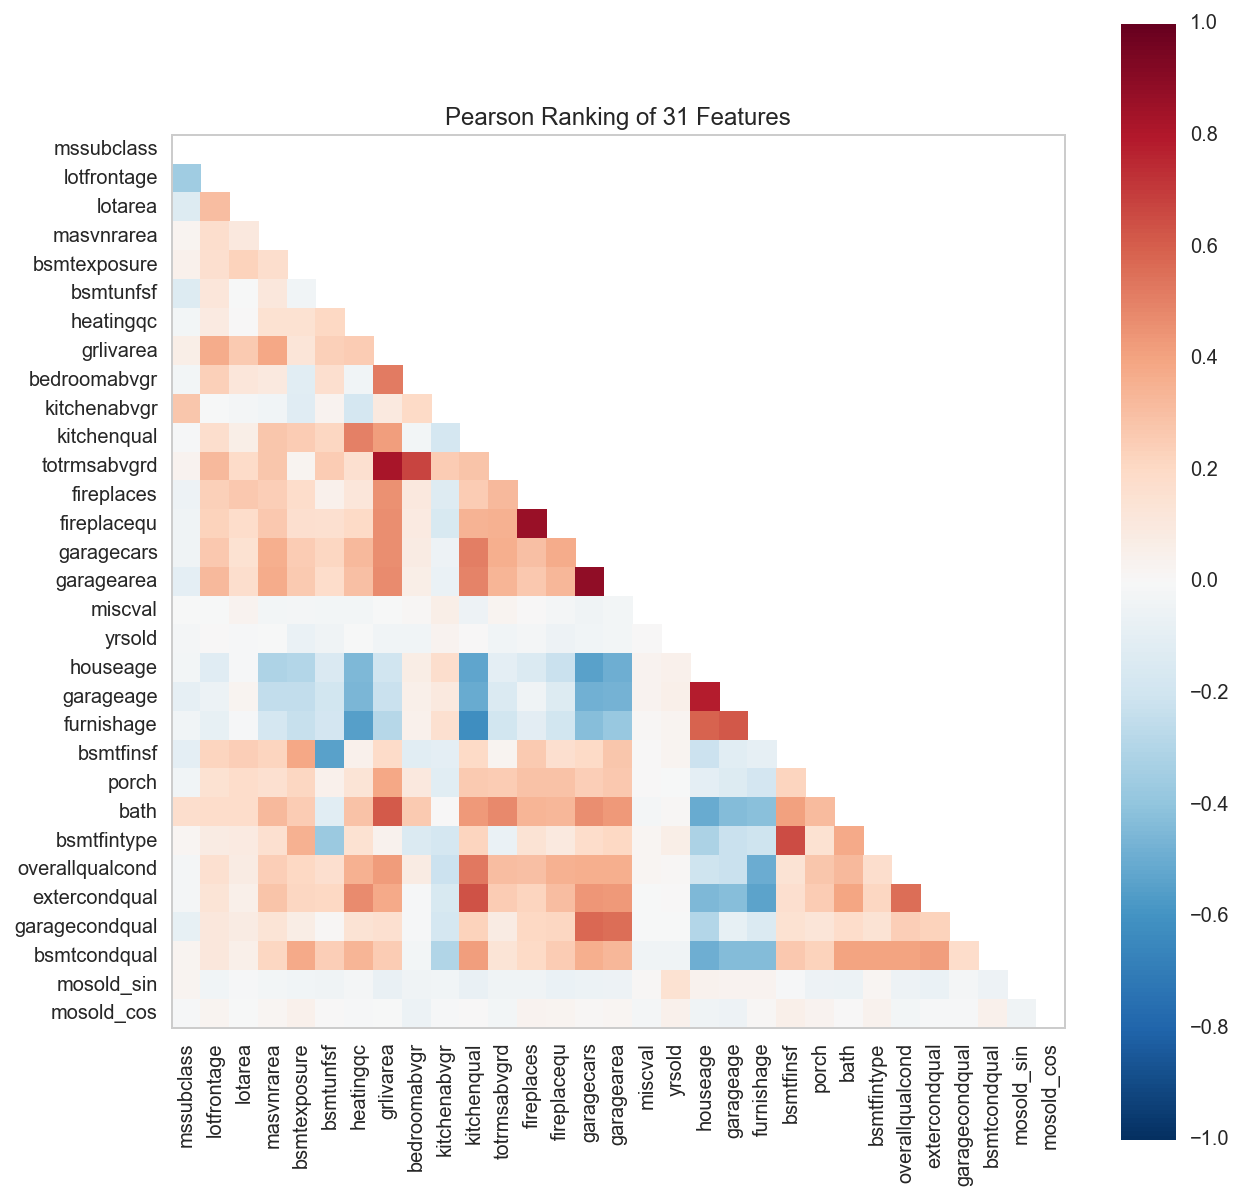

In [829]:
plt.figure(figsize=(10,10))
visualizer = Rank2D()
visualizer.fit(X,y)
visualizer.transform(X)
visualizer.poof()

>Firstly garagecars and garagearea are highly correlated. We will drop garagecars as it looks to have higher correlation with other variables. Next, we can observed that fireplacequ and fireplaces are also highly correlated. We will drop fireplacequ as it too looks to have higher correlation with other variables. houseage and garagage look to be rather highly correlated too. We will drop houseage in favour of the other variable with lower correlation to other predictors. Finally, totrmsabvdrd looks to be highly correlated with grlivarea and bedroomabvgr. Let's investigate!

In [830]:
house.drop(['garagecars', 'fireplacequ', 'houseage'], axis=1, inplace=True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [831]:
observed = pd.crosstab(house['totrmsabvgrd'], house['bedroomabvgr'])
chi2_contingency(observed)

(2976.3876070778488,
 0.0,
 77,
 array([[  4.13793103e-03,   3.37931034e-02,   2.42758621e-01,
           5.53103448e-01,   1.46206897e-01,   1.44827586e-02,
           4.82758621e-03,   6.89655172e-04],
        [  7.03448276e-02,   5.74482759e-01,   4.12689655e+00,
           9.40275862e+00,   2.48551724e+00,   2.46206897e-01,
           8.20689655e-02,   1.17241379e-02],
        [  3.88965517e-01,   3.17655172e+00,   2.28193103e+01,
           5.19917241e+01,   1.37434483e+01,   1.36137931e+00,
           4.53793103e-01,   6.48275862e-02],
        [  1.13793103e+00,   9.29310345e+00,   6.67586207e+01,
           1.52103448e+02,   4.02068966e+01,   3.98275862e+00,
           1.32758621e+00,   1.89655172e-01],
        [  1.64689655e+00,   1.34496552e+01,   9.66179310e+01,
           2.20135172e+02,   5.81903448e+01,   5.76413793e+00,
           1.92137931e+00,   2.74482759e-01],
        [  1.35310345e+00,   1.10503448e+01,   7.93820690e+01,
           1.80864828e+02,   4.78096552e+01, 

>It seems reasonable to understand why a relationship is observed between number of bedrooms above grade and total number of rooms above grade, which is further proven by the significant chi<sup>2</sup> test result. Let's look at the relationship between totrmsabvgrd, a categorical variable, and the grlivarea, a continuous one using an ANOVA one-way test.

In [832]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod = ols('grlivarea ~ totrmsabvgrd',
                data=house).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

                    sum_sq      df            F  PR(>F)
totrmsabvgrd  2.721091e+08     1.0  3090.157687     0.0
Residual      1.275061e+08  1448.0          NaN     NaN


> There is a significant relationship between both variables as evidenced by the low p-value of the ANOVA test. We'll drop totrmsabvgrd as a potential predictor.

In [833]:
house.drop('totrmsabvgrd', axis=1, inplace=True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


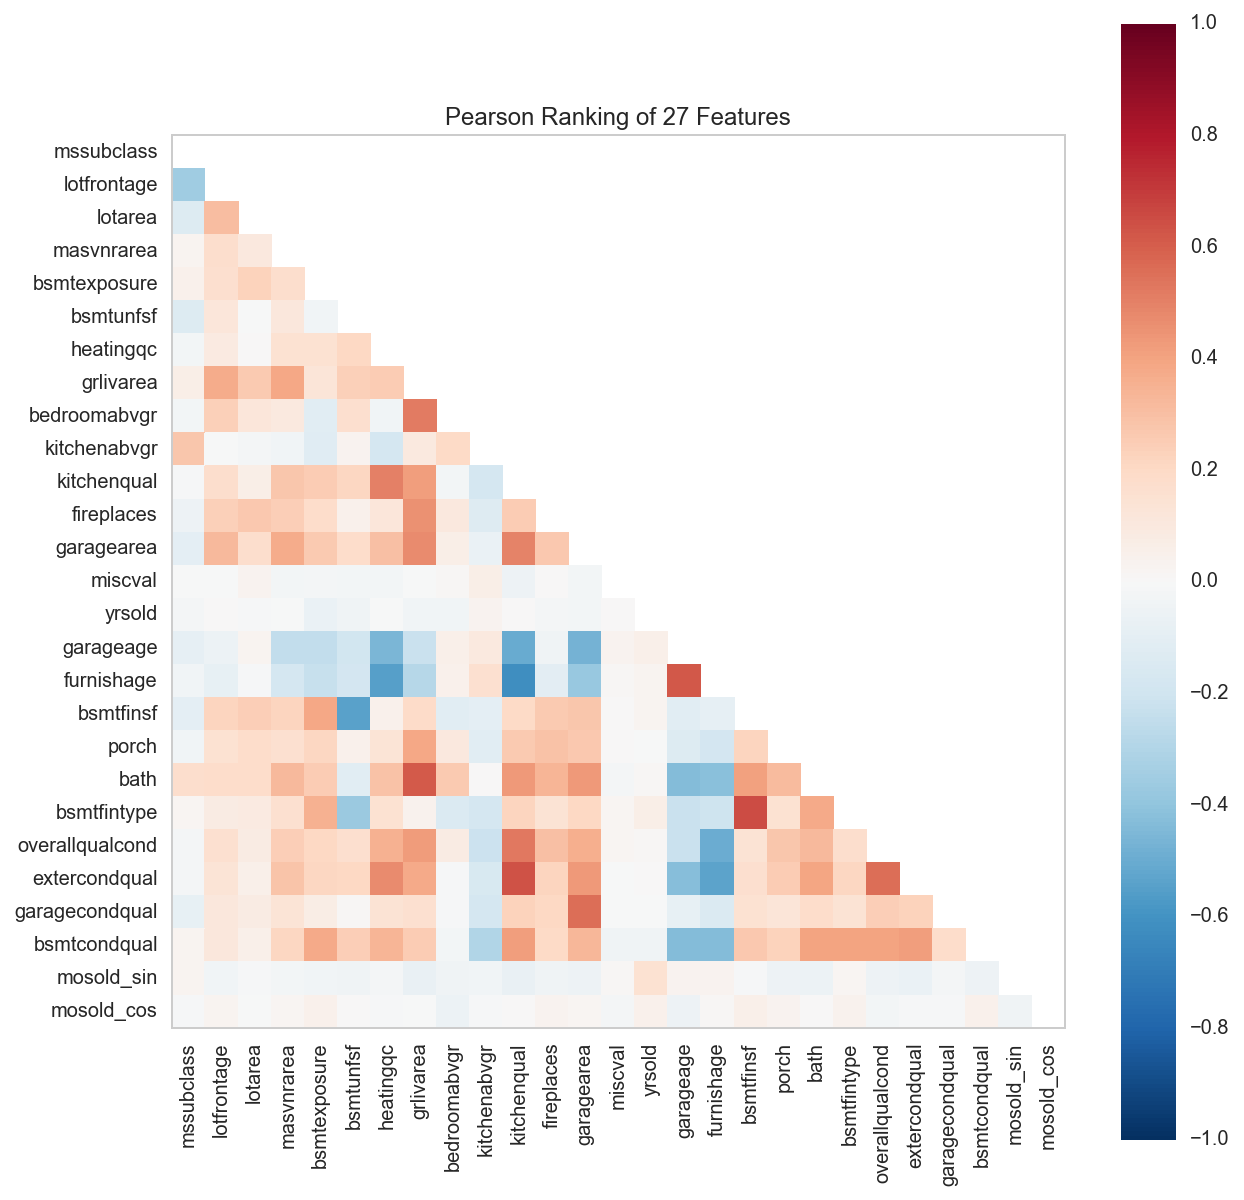

In [834]:
continuous_features = house._get_numeric_data()
y = continuous_features['saleprice']
X = continuous_features.drop('saleprice', axis=1)
plt.figure(figsize=(10,10))
visualizer = Rank2D()
visualizer.fit(X,y)
visualizer.transform(X)
visualizer.poof()

>The correlation among predictor variables look reasonably minimal now. Let's do a further check with the Variance Inflation Factor (VIF).

### Variance Inflation Factor
The Variance Inflation Factor (VIF) checks to see if any of the features in a dataset tends to exhibit multicollinearity with other variables. This is accomplished through an analysis of the variance of the coefficient of a feature compared to the other features in a multiple linear regression. A VIF more than 5 indicates high correlation while values between 1-5 show moderate correlation

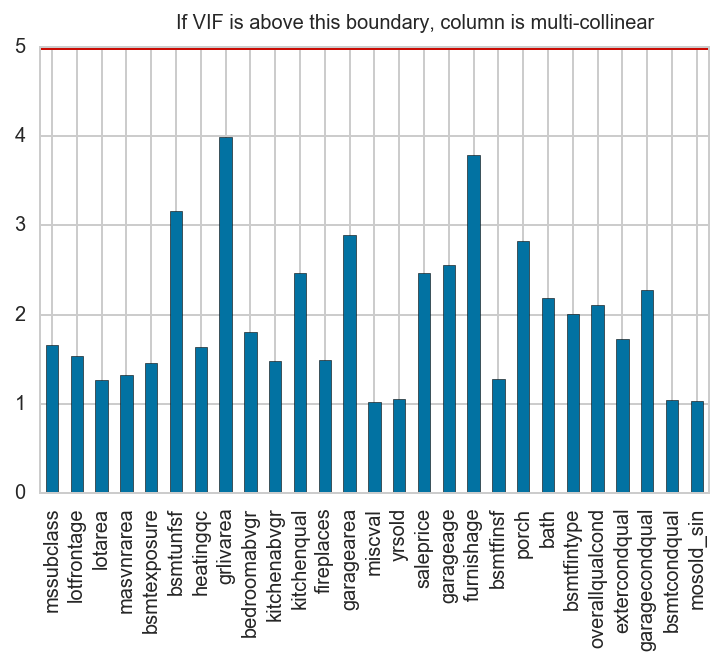

In [835]:
#We need to standardize our features first
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

from statsmodels.stats.outliers_influence import variance_inflation_factor

VIF = [(continuous_features.columns[i], variance_inflation_factor(Xs, i)) for i in range(Xs.shape[1])]

VIF_df = pd.DataFrame(list(zip(*VIF)[1]), index = list(zip(*VIF)[0]))

fig, ax = plt.subplots()
VIF_df.plot(kind = 'bar', legend = False, ax = ax)
ax.axhline(5, c = 'r', lw = 3)
ax.text(5, 5.2, 'If VIF is above this boundary, column is multi-collinear')
plt.show()

>It would seem that none of our other features are highly correlated with each other although several features are moderately correlated. 

## Low variance check
We next identify features with low or near zero variance through the following function. Near zero variance features are qualified as those with a 19x difference in the highest value to the next highest value including having the total number of distinct values to be less than 10% of the total number of samples.

In [836]:
def nearZeroVariance(X, freqCut = 95 / 5, uniqueCut = 10):
    '''
    Determine predictors with near zero or zero variance.
    Inputs:
    X: pandas data frame
    freqCut: the cutoff for the ratio of the most common value to the second most common value
    uniqueCut: the cutoff for the percentage of distinct values out of the number of total samples
    Returns a tuple containing a list of column names: (zeroVar, nzVar)
    '''

    colNames = X.columns.values.tolist()
    freqRatio = dict()
    uniquePct = dict()

    for names in colNames:
        counts = (
            (X[names])
            .value_counts()
            .sort_values(ascending = False)
            .values
            )

        if len(counts) == 1:
            freqRatio[names] = -1
            uniquePct[names] = (float(len(counts)) / len(X[names])) * 100
            continue

        freqRatio[names] = counts[0] / counts[1]
        uniquePct[names] = (float(len(counts)) / len(X[names])) * 100

    zeroVar = list()
    nzVar = list()
    for k in uniquePct.keys():
        if freqRatio[k] == -1:
            zeroVar.append(k)

        if uniquePct[k] < uniqueCut and freqRatio[k] > freqCut:
            nzVar.append(k)

    return(zeroVar, nzVar)

In [837]:
X = house.drop('saleprice', axis=1)

In [838]:
zeroVar, nzVar = nearZeroVariance(X)

In [839]:
print zeroVar, nzVar

[] ['landslope', 'functional', 'kitchenabvgr', 'roofmatl', 'street', 'landcontour', 'miscval', 'utilities', 'heating']


>These are the featrues that are identified to have low variance. Let's take a look at their distribution.

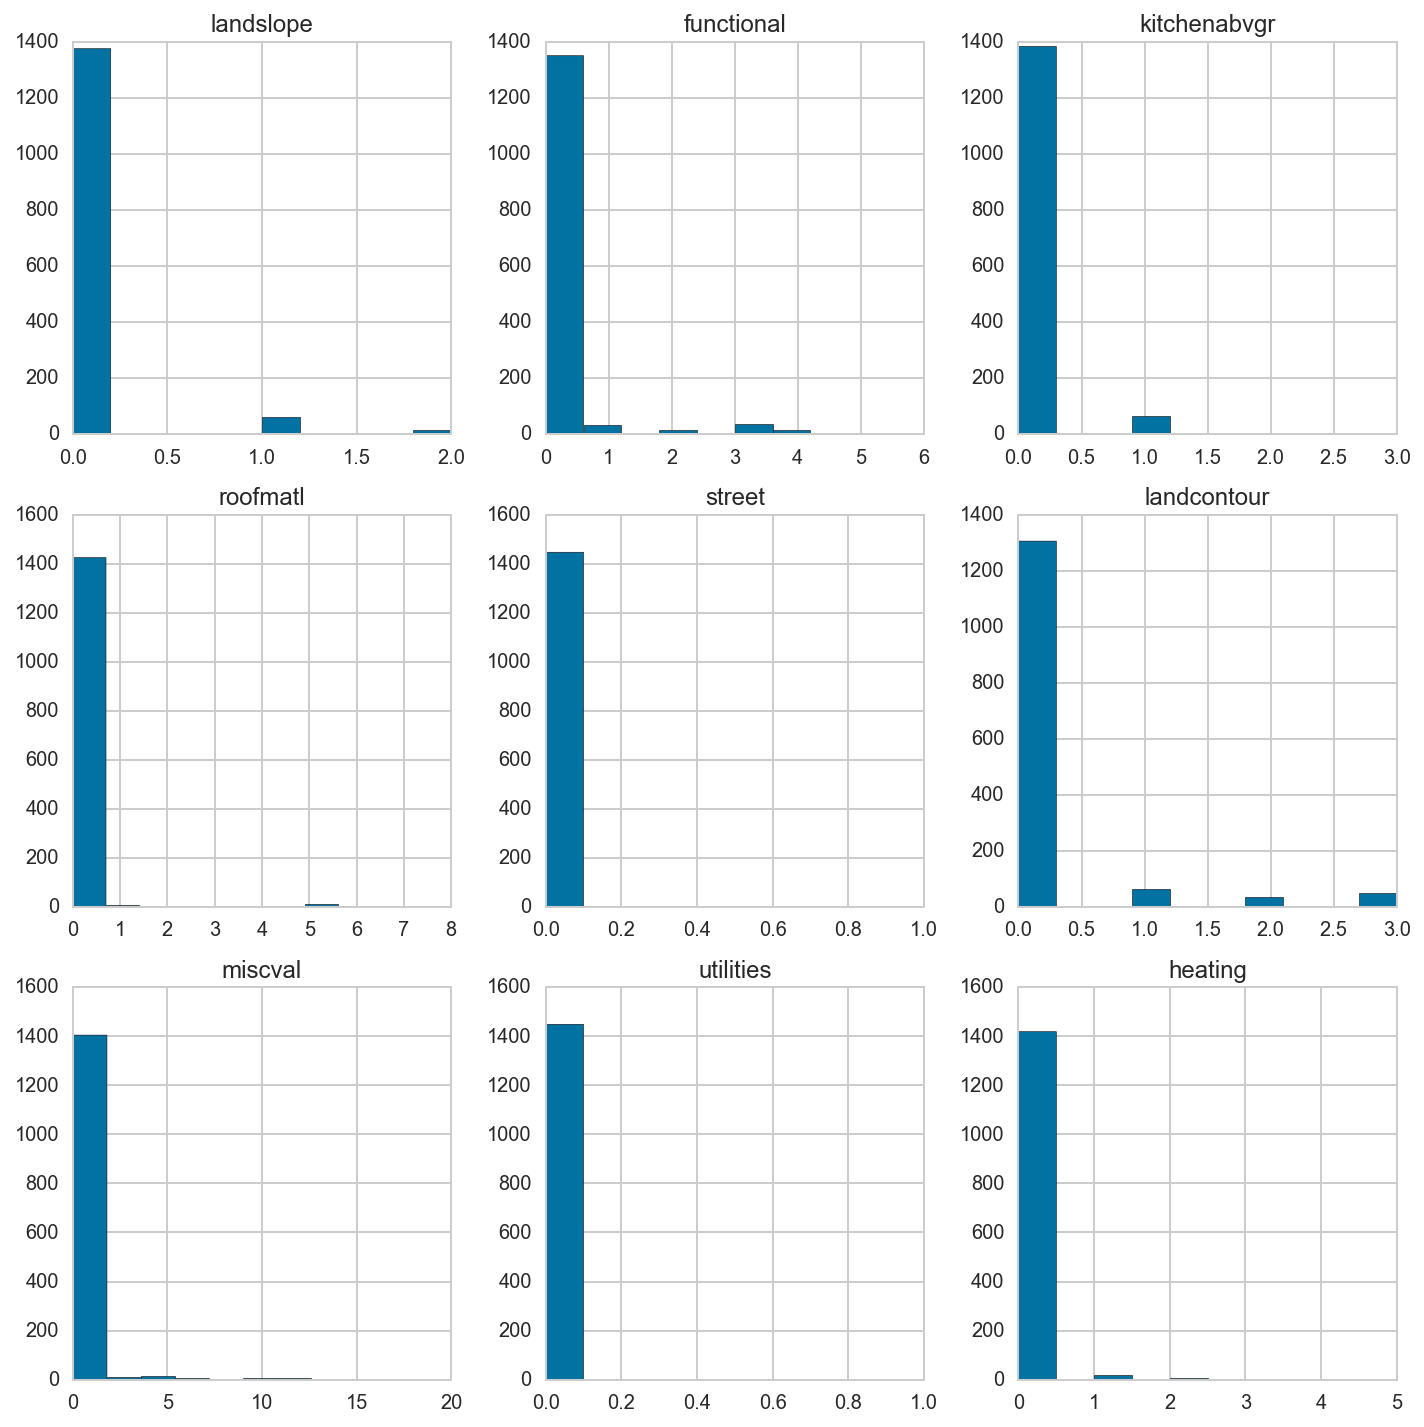

In [840]:
features = house.loc[:, ['landslope', 'functional', 'kitchenabvgr', 'roofmatl', 'street', 'landcontour', 'miscval',
                         'utilities', 'heating']]

fig, ax = plt.subplots(nrows=3, ncols = 3, figsize = (10,10))

for idx, col_name in enumerate(features.columns):
    row = int(idx / 3)
    col = int(idx % 3)
    ax[row][col].set_title(col_name)
    ax[row][col].hist(house[col_name].factorize()[0])

plt.tight_layout()

fig.patch.set_facecolor('white')

>We can indeed observe the high prevalence for one value, the 0 value, and minimal contribution by the others. We will drop these features from our dataset.

In [841]:
house.drop(['landslope', 'functional', 'kitchenabvgr', 'roofmatl', 'street', 'landcontour', 'miscval',
                         'utilities', 'heating'], axis=1, inplace=True)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [842]:
house.shape

(1450, 44)

> We've reduced the initial 81 features into 44. Let's finish our preprocessing work which includes converting our categorical variables into dummy variables and standardizing our continuous variables

## Patsy

In [843]:
house.columns

Index([u'mssubclass', u'mszoning', u'lotfrontage', u'lotarea', u'lotshape',
       u'lotconfig', u'neighborhood', u'bldgtype', u'housestyle', u'roofstyle',
       u'masvnrtype', u'masvnrarea', u'foundation', u'bsmtexposure',
       u'bsmtunfsf', u'heatingqc', u'centralair', u'electrical', u'grlivarea',
       u'bedroomabvgr', u'kitchenqual', u'fireplaces', u'garagetype',
       u'garagefinish', u'garagearea', u'paveddrive', u'yrsold', u'saletype',
       u'salecondition', u'saleprice', u'garageage', u'furnishage',
       u'condition', u'exterior', u'bsmtfinsf', u'porch', u'bath',
       u'bsmtfintype', u'overallqualcond', u'extercondqual', u'garagecondqual',
       u'bsmtcondqual', u'mosold_sin', u'mosold_cos'],
      dtype='object')

In [844]:
#Let's first split into fixed features and features that can be modified.
fixed_features = ['mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'lotshape', 
                'lotconfig', 'neighborhood', 'bldgtype', 'housestyle', 'masvnrarea','foundation', 'bsmtunfsf','grlivarea',
                  'bedroomabvgr', 'fireplaces', 'garagetype', 'mosold_sin', 'mosold_cos', 'furnishage', 'condition',
                 'garagearea', 'yrsold', 'garageage', 'bsmtfinsf', 'porch', 'bath']

renovatable_features = ['roofstyle','masvnrtype', 'bsmtexposure', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
                        'garagefinish', 'paveddrive', 'exterior', 'bsmtfintype', 'overallqualcond', 'extercondqual',
                       'garagecondqual', 'bsmtcondqual']
print len(fixed_features), len(renovatable_features)

26 15


>Ive left out the dependent variable, saleprice, as well as saletype and salecondition as they do not factor into a fixed feature of a house and neither are they renovatable ones.

In [845]:
house_fixed = house.loc[:, house.columns.isin(fixed_features)]

## Setup X_fixed and y_fixed with patsy

In [846]:
import patsy

formula = 'saleprice ~ '+' + '.join([c for c in house_fixed.columns]) + ' -1'
print formula
y_fixed, X_fixed = patsy.dmatrices(formula, data=house, return_type='dataframe')
y_fixed = y_fixed.values.ravel()

print X_fixed.shape, y_fixed.shape

saleprice ~ mssubclass + mszoning + lotfrontage + lotarea + lotshape + lotconfig + neighborhood + bldgtype + housestyle + masvnrarea + foundation + bsmtunfsf + grlivarea + bedroomabvgr + fireplaces + garagetype + garagearea + yrsold + garageage + furnishage + condition + bsmtfinsf + porch + bath + mosold_sin + mosold_cos -1
(1450, 90) (1450,)


Patsy dmatrices has expanded the number of features from 26 to 90 to include dummy variables for all categorical columns.

## train test split
>We want to train on pre 2010 data and test on 2010 data

In [847]:
X_fixed_test = X_fixed.loc[house['yrsold'] == 2010, :]

In [848]:
X_fixed_test.shape

(172, 90)

In [849]:
X_fixed_train = X_fixed.loc[house['yrsold'] != 2010,:]

In [850]:
X_fixed_train.shape

(1278, 90)

In [851]:
y_fixed_test = y_fixed[house['yrsold'] == 2010]

In [852]:
y_fixed_test.shape

(172,)

In [853]:
y_fixed_train = y_fixed[house['yrsold'] != 2010]

In [854]:
y_fixed_train.shape

(1278,)

In [855]:
print 'Test set percentage of data: {0:.2f}'.format(float(y_fixed_test.shape[0])/y_fixed.shape[0] * 100)+'%'

Test set percentage of data: 11.86%


>Our test set is about 11.86% of our dataset.

# Modeling
>We will be performing linear regression on the fixed features first to get a baseline R<sup>2</sup> score. Then we will perform regression with regularization to improve prediction accuracy through the wrapper methods of feature selection. These include ridge, lasso and elastic net regression models. Next we explore a stochastic gradient descent regressor method using gridsearch and finally we model with a decision tree regressor using gradient boosting with gridsearch over its hyperparameters. 

>We first create a function that will allow us to easily print out the RMSE evaluation metric for each model, the R<sup>2</sup> accuracy, as well as either a plot of coefficient scores or feature importances.

In [1092]:
from sklearn.preprocessing import StandardScaler
def model(clf, X_train, X_test, y_train, y_test, bar_plot=True):
    ss=StandardScaler()
    Xs_train = ss.fit_transform(X_train)
    Xs_test = ss.fit_transform(X_test)
    
    model = clf.fit(Xs_train, y_train)
    yhat = model.predict(Xs_test)
    
    print 'Model Report:'
    print 'RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, yhat))
    print 'Accuracy: ', metrics.r2_score(y_test, yhat)
    if bar_plot ==True:
        try:
            feat_imp = pd.Series(clf.feature_importances_, X_train.columns).sort_values(ascending=False)
            fig, ax = plt.subplots(figsize=(13,8))
            feat_imp.head(40).plot(kind='bar', title='Feature Importance', ax=ax)
            plt.ylabel('Feature importance score')
            
        except AttributeError:
            coef_ranking = pd.Series(abs(clf.coef_), X_train.columns).sort_values(ascending=False)
            fig, ax = plt.subplots(figsize=(13,8))
            coef_ranking.head(40).plot(kind='bar', title='Coefficient Ranking', ax=ax)
            plt.ylabel('Coefficient Scores')

> Our scaler of choice is a Standard Scaler where we normalize each feature to 0 mean and a standard deviation of 1. It is included in our 'model' function.

## Linear Regression

In [858]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [859]:
model(LinearRegression(), X_fixed_train, X_fixed_test, y_fixed_train, y_fixed_test, bar_plot=False)

Model Report:
RMSE:  3.85742763419e+14
Accuracy:  -2.34054016647e+19


>The negative R<sup>2</sup> score of our linear regression suggests that our model still has features that are multicollinear.

## Ridge Regression

In [860]:
from sklearn.linear_model import RidgeCV

In [861]:
alpha_range = np.logspace(-10, 5, 200)
ridgeregcv = RidgeCV(alphas=alpha_range, scoring='neg_mean_squared_error', cv=3)

Model Report:
RMSE:  30884.5226301
Accuracy:  0.849961639539


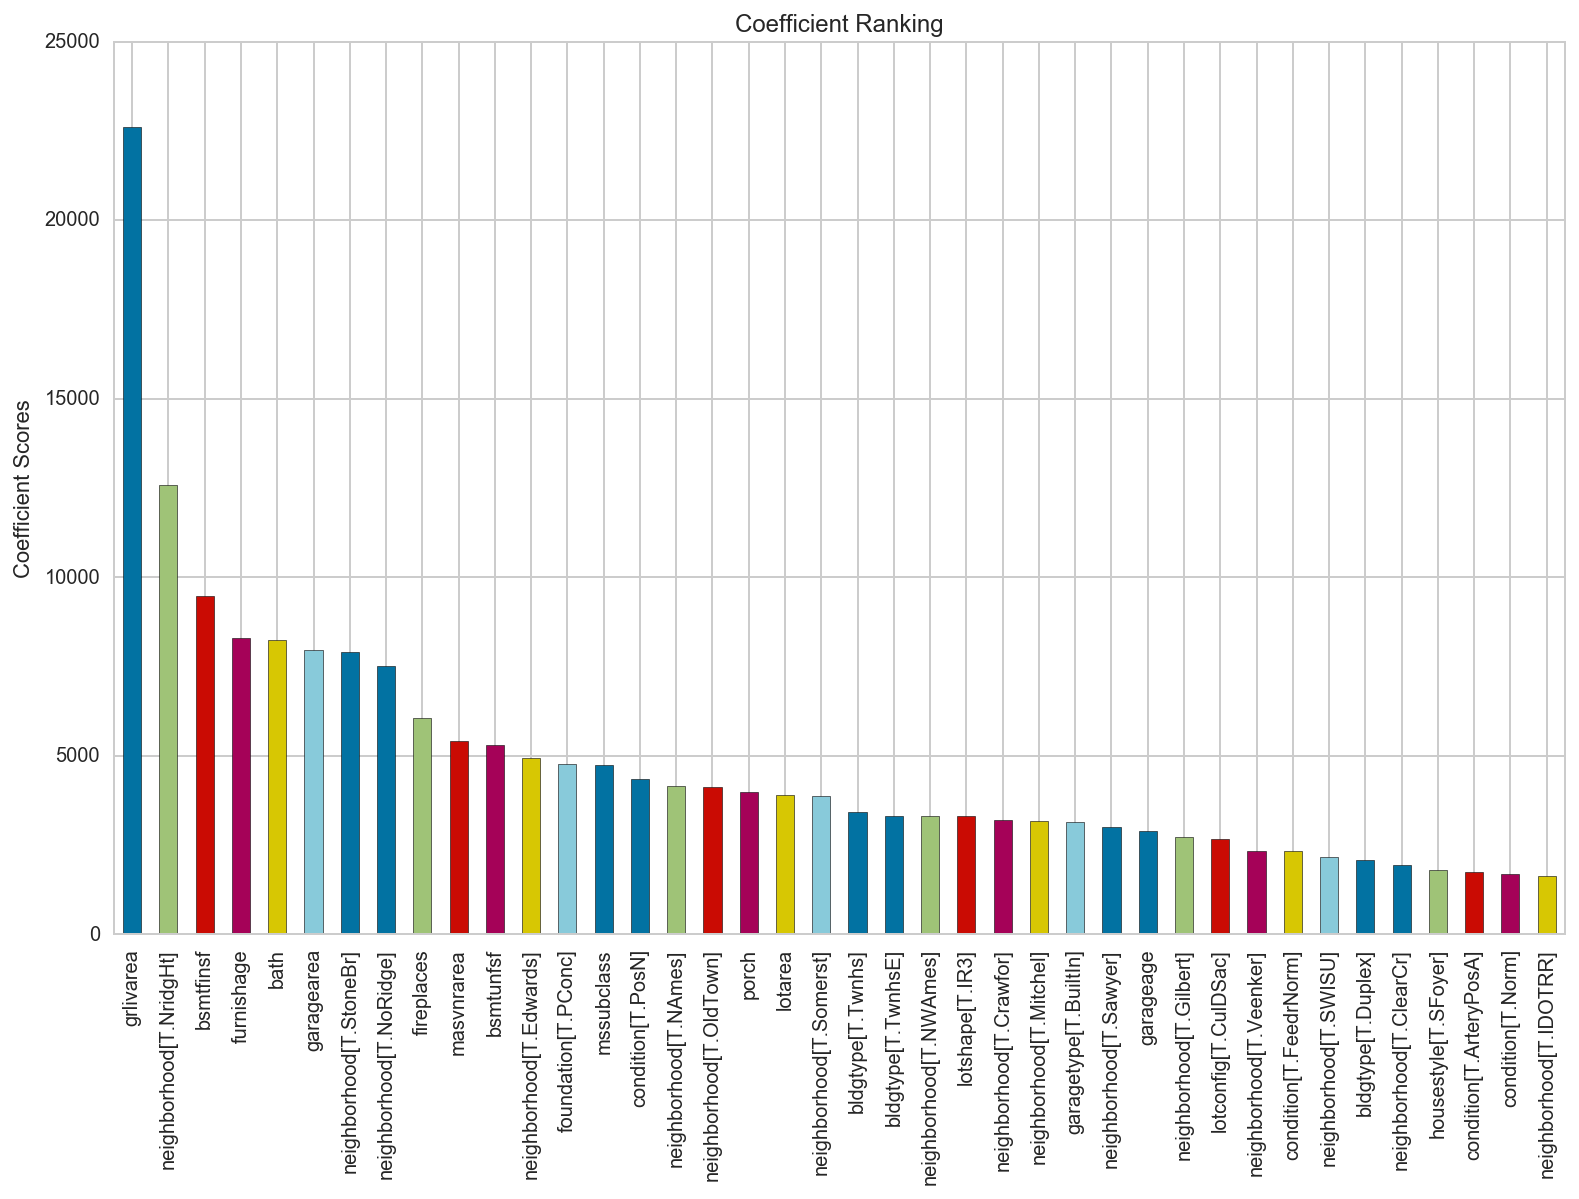

In [862]:
model(ridgeregcv, X_fixed_train, X_fixed_test, y_fixed_train, y_fixed_test)

>We can see that the coefficient with the greatest score is about 2x more in magnitude than the coefficient with the 2nd largest value.

## Lasso Regression

In [863]:
from sklearn.linear_model import LassoCV

In [864]:
lassoregcv = LassoCV(n_alphas=100)

Model Report:
RMSE:  30729.9549562
Accuracy:  0.851459674557


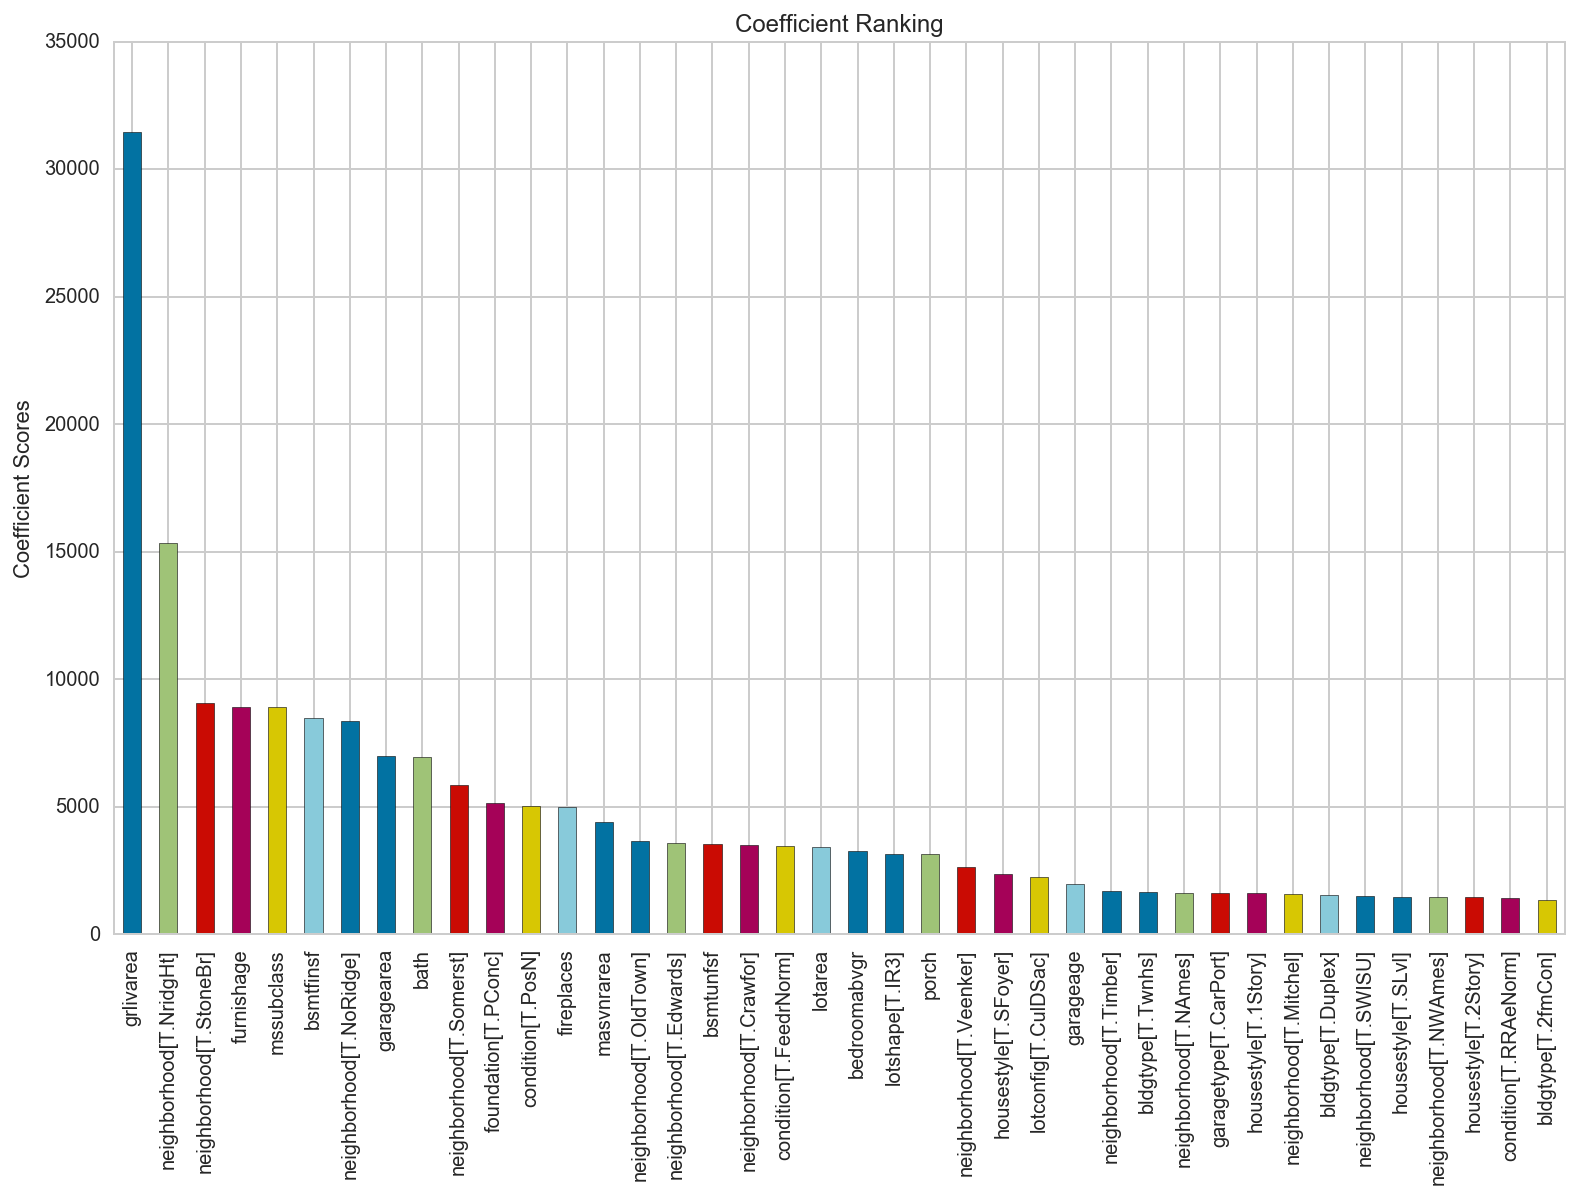

In [865]:
model(lassoregcv, X_fixed_train, X_fixed_test, y_fixed_train, y_fixed_test)

>The values of the coefficients in the lasso regression model are higher than those in the ridge as several coefficients have been reduced to 0. grlivarea tops out at 31,000, compared to 23,000 in ridge. The proportion of differences between the top 40 coefficients also look to be similar to that of the Ridge regression.

In [866]:
lasso_coefs = pd.DataFrame({'variable':X_fixed.columns, 'coefs':lassoregcv.coef_, 'abs_coefs':np.abs(lassoregcv.coef_)})
lasso_coefs.sort_values('abs_coefs', ascending=False)

,abs_coefs,coefs,variable
78,31438.001406,31438.001406,grlivarea
26,15338.156363,15338.156363,neighborhood[T.NridgHt]
32,9060.859136,9060.859136,neighborhood[T.StoneBr]
84,8926.018511,-8926.018511,furnishage
73,8922.381050,-8922.381050,mssubclass
85,8489.107230,8489.107230,bsmtfinsf
25,8375.727227,8375.727227,neighborhood[T.NoRidge]
81,6994.661893,6994.661893,garagearea
87,6966.489331,6966.489331,bath
31,5842.503191,5842.503191,neighborhood[T.Somerst]


In [867]:
np.sum(lassoregcv.coef_!=0)

64

In [868]:
lasso_coefs['variable'].loc[lassoregcv.coef_ == 0]

0                mszoning[FV]
1                mszoning[RH]
2                mszoning[RL]
3                mszoning[RM]
6             lotshape[T.Reg]
11    neighborhood[T.Blueste]
13    neighborhood[T.BrkSide]
18    neighborhood[T.Gilbert]
20    neighborhood[T.MeadowV]
30    neighborhood[T.SawyerW]
42       housestyle[T.2.5Unf]
46       foundation[T.CBlock]
48         foundation[T.Slab]
49        foundation[T.Stone]
52      garagetype[T.Basment]
55       garagetype[T.Detchd]
56           garagetype[T.NA]
61     condition[T.FeedrRRAn]
62     condition[T.FeedrRRNn]
64      condition[T.PosANorm]
66      condition[T.PosNNorm]
69      condition[T.RRAnNorm]
70      condition[T.RRNeNorm]
71     condition[T.RRNnFeedr]
74                lotfrontage
88                 mosold_sin
Name: variable, dtype: object

> The list of 26 features that have their coefficients set to 0 shows that they exhibit correlation with other features in our dataset. While this tries to reduce multicollinearity, it does not mean that these features are not important in predicting the dependent variable. The arbitrary dropping of a feature due to its high correlation with another feature provides us with less ability in correctly interpreting feature importance in deciding what to look out for to predict housing prices.

## ElasticNet

In [869]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

In [870]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=3, random_state=123)
optimal_enet.fit(Xs_fixed_train, y_fixed_train)
print optimal_enet.alpha_
print optimal_enet.l1_ratio_

559.941054205
1.0


In [871]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

In [872]:
model(enet, X_fixed_train, X_fixed_test, y_fixed_train, y_fixed_test, bar_plot=False)

Model Report:
RMSE:  30729.9549562
Accuracy:  0.851459674557


> The results of the elastic net modeling shows that our best model so far is a lasso regression one.

## SGDRegressor with GridsearchCV
> In this model, we perform a stochastic gradient descent routine to minimize the error function. Scikit learn provides a class that we can easily employ our model with. Performing a gridsearchCV over the hyperparameters help us optimize for the model. 

In [873]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

In [874]:
sgd_params = {'loss':['squared_loss','huber'],
              'penalty':['l1','l2'],
              'alpha':np.logspace(-5,1,100),
              'learning_rate': ['constant', 'optimal', 'invscaling']
}

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs_fixed_train = ss.fit_transform(X_fixed_train)
Xs_fixed_test = ss.fit_transform(X_fixed_test)
print Xs_fixed_train.shape, Xs_fixed_test.shape

In [875]:
sgd_reg = SGDRegressor(random_state=123)
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=4, verbose=False, iid=False)
sgd_reg_gs.fit(Xs_fixed_train, y_fixed_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=5, n_iter=None, penalty='l2',
       power_t=0.25, random_state=123, shuffle=True, tol=None, verbose=0,
       warm_start=False),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss', 'huber'], 'learning_rate': ['constant', 'optimal', 'invscaling'], 'alpha': array([  1.00000e-05,   1.14976e-05, ...,   8.69749e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=False)

In [876]:
print sgd_reg_gs.best_params_
print sgd_reg_gs.best_score_
sgd_reg = sgd_reg_gs.best_estimator_

{'penalty': 'l2', 'alpha': 0.2310129700083158, 'learning_rate': 'invscaling', 'loss': 'squared_loss'}
0.754707390276


In [877]:
model(sgd_reg, X_fixed_train, X_fixed_test, y_fixed_train, y_fixed_test, bar_plot=False)

Model Report:
RMSE:  32293.258896
Accuracy:  0.835962072955


> The scores are not as good as those from either Lasso or Ridge

### Gradient Boosting Regressor
> In the gradient boosting regressor, several weak learners are added together to boost the accuracy of the model. Each learner has a high bias but low variance. By combining successive iterations of learners, the model is able to reduce the bias gradually while keeping variance low.

>We will be using Sklearn's implementation of the regressor and tuning its hyperparameters over several iterations.

In [878]:
from sklearn.ensemble import GradientBoostingRegressor

In [879]:
gbr_base = GradientBoostingRegressor(random_state=123)

In [856]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs_fixed_train = ss.fit_transform(X_fixed_train)
Xs_fixed_test = ss.fit_transform(X_fixed_test)
Xs_fixed = ss.fit_transform(X_fixed)
print Xs_fixed_train.shape, Xs_fixed_test.shape

(1278, 90) (172, 90)


In [880]:
gbr_base.fit(Xs_fixed_train, y_fixed_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=123,
             subsample=1.0, verbose=0, warm_start=False)

In [881]:
model(gbr_base, X_fixed_train, X_fixed_test, y_fixed_train, y_fixed_test, bar_plot=False)

Model Report:
RMSE:  26878.083128
Accuracy:  0.886363693545


> The base model, before tuning for its hyperparameters, already registers a better score than all the previous regression models.

> We first tune for the number of estimators or trees. It should be noted that we do not select a large value here first as it will increase the computation time.

In [882]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(max_features='sqrt',random_state=123), 
                        param_grid = param_test1, n_jobs=-1,iid=False, cv=5)

In [883]:
%time gsearch1.fit(Xs_fixed_train, y_fixed_train)

CPU times: user 610 ms, sys: 106 ms, total: 716 ms
Wall time: 1.78 s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=123, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [884]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 80}, 0.83516675370867444)

> We input the best number of estimators into our next set of gridsearching where we try to find how many levels the tree should split into and also how many samples there should be at least in each node before splitting. These are tree-related hyperparameters that we will be attempting to set first.

In [885]:
param_test2 = {'max_depth':range(2,17,2), 'min_samples_split':range(2,17,2)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators=80, max_features='sqrt', random_state=123), 
param_grid = param_test2,n_jobs=-1,iid=False, cv=5)

In [886]:
%time gsearch2.fit(Xs_fixed_train, y_fixed_train)

CPU times: user 1.88 s, sys: 380 ms, total: 2.26 s
Wall time: 29.1 s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=80, presort='auto',
             random_state=123, subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [887]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 4, 'min_samples_split': 10}, 0.85355510340917784)

> We continue tuning another aspect of the tree hyperparameter, the minimum number of samples in each leaf node, for the 3rd routine.

In [888]:
param_test3 = {'min_samples_leaf':range(2,11)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(max_depth=4, min_samples_split=10, n_estimators=80, max_features='sqrt', random_state=123), 
param_grid = param_test3, n_jobs=-1, iid=False, cv=5)

In [889]:
%time gsearch3.fit(Xs_fixed_train, y_fixed_train)

CPU times: user 539 ms, sys: 108 ms, total: 647 ms
Wall time: 1.87 s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=80, presort='auto',
             random_state=123, subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [890]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 2}, 0.85572841187059367)

> With our tree hyperparameters tuned, we now look at how many features the algorithm should consider at most when looking at splitting, as well as the loss function.

In [891]:
param_test4 = {'max_features': ['sqrt', 'log2'], 'loss': ['ls', 'lad', 'huber']}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(max_depth=4, min_samples_split=10, min_samples_leaf = 2, n_estimators=80, random_state=123), 
param_grid = param_test4, n_jobs=-1, iid=False, cv=5)

In [892]:
%time gsearch4.fit(Xs_fixed_train, y_fixed_train)

CPU times: user 507 ms, sys: 113 ms, total: 619 ms
Wall time: 3.29 s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=2,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=80, presort='auto', random_state=123,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_features': ['sqrt', 'log2'], 'loss': ['ls', 'lad', 'huber']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [893]:
gsearch4.best_params_, gsearch4.best_score_

({'loss': 'ls', 'max_features': 'sqrt'}, 0.85572841187059367)

> The subsample hyperparameter indicates what percentage of all the samples should be used for each individual weak learner. Any value below the default of 1.0 results in Stochastic Gradient boosting, reducing variance but increasing bias.

In [894]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(max_depth=4, min_samples_split=10, min_samples_leaf = 2,max_features='sqrt', n_estimators=80, random_state=123), 
param_grid = param_test5, n_jobs=-1, iid=False, cv=5)

In [895]:
%time gsearch5.fit(Xs_fixed_train, y_fixed_train)

CPU times: user 532 ms, sys: 110 ms, total: 642 ms
Wall time: 1.62 s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=2, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=80, presort='auto',
             random_state=123, subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [896]:
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.85}, 0.84356674993247494)

>The final parameters we will be tuning are the learning rate and the n_estimators, 2 hyperparameters that are inversely related to each other. The learning rate has to decrease to reduce the effect of each estimator in the overall model as the number of estimators increase

In [1061]:
param_test6 = {'learning_rate':[0.05, 0.01, 0.005, 0.001], 'n_estimators': [160, 800, 1600, 3200, 6400, 12800, 25600]}
gsearch6 = GridSearchCV(estimator = GradientBoostingRegressor(subsample=0.85, max_depth=4, min_samples_split=10, min_samples_leaf = 2,max_features='sqrt', random_state=123), 
param_grid = param_test6, n_jobs=-1, iid=False, cv=5)

In [1062]:
%time gsearch6.fit(Xs_fixed_train, y_fixed_train)

CPU times: user 8.58 s, sys: 1.8 s, total: 10.4 s
Wall time: 7min 25s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=2, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=123, subsample=0.85, verbose=0,
             warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'n_estimators': [160, 800, 1600, 3200, 6400, 12800, 25600], 'learning_rate': [0.05, 0.01, 0.005, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [1063]:
gsearch6.best_params_, gsearch6.best_score_

({'learning_rate': 0.005, 'n_estimators': 6400}, 0.86816654113842717)

Model Report:
RMSE:  24047.6741039
Accuracy:  0.909036601209


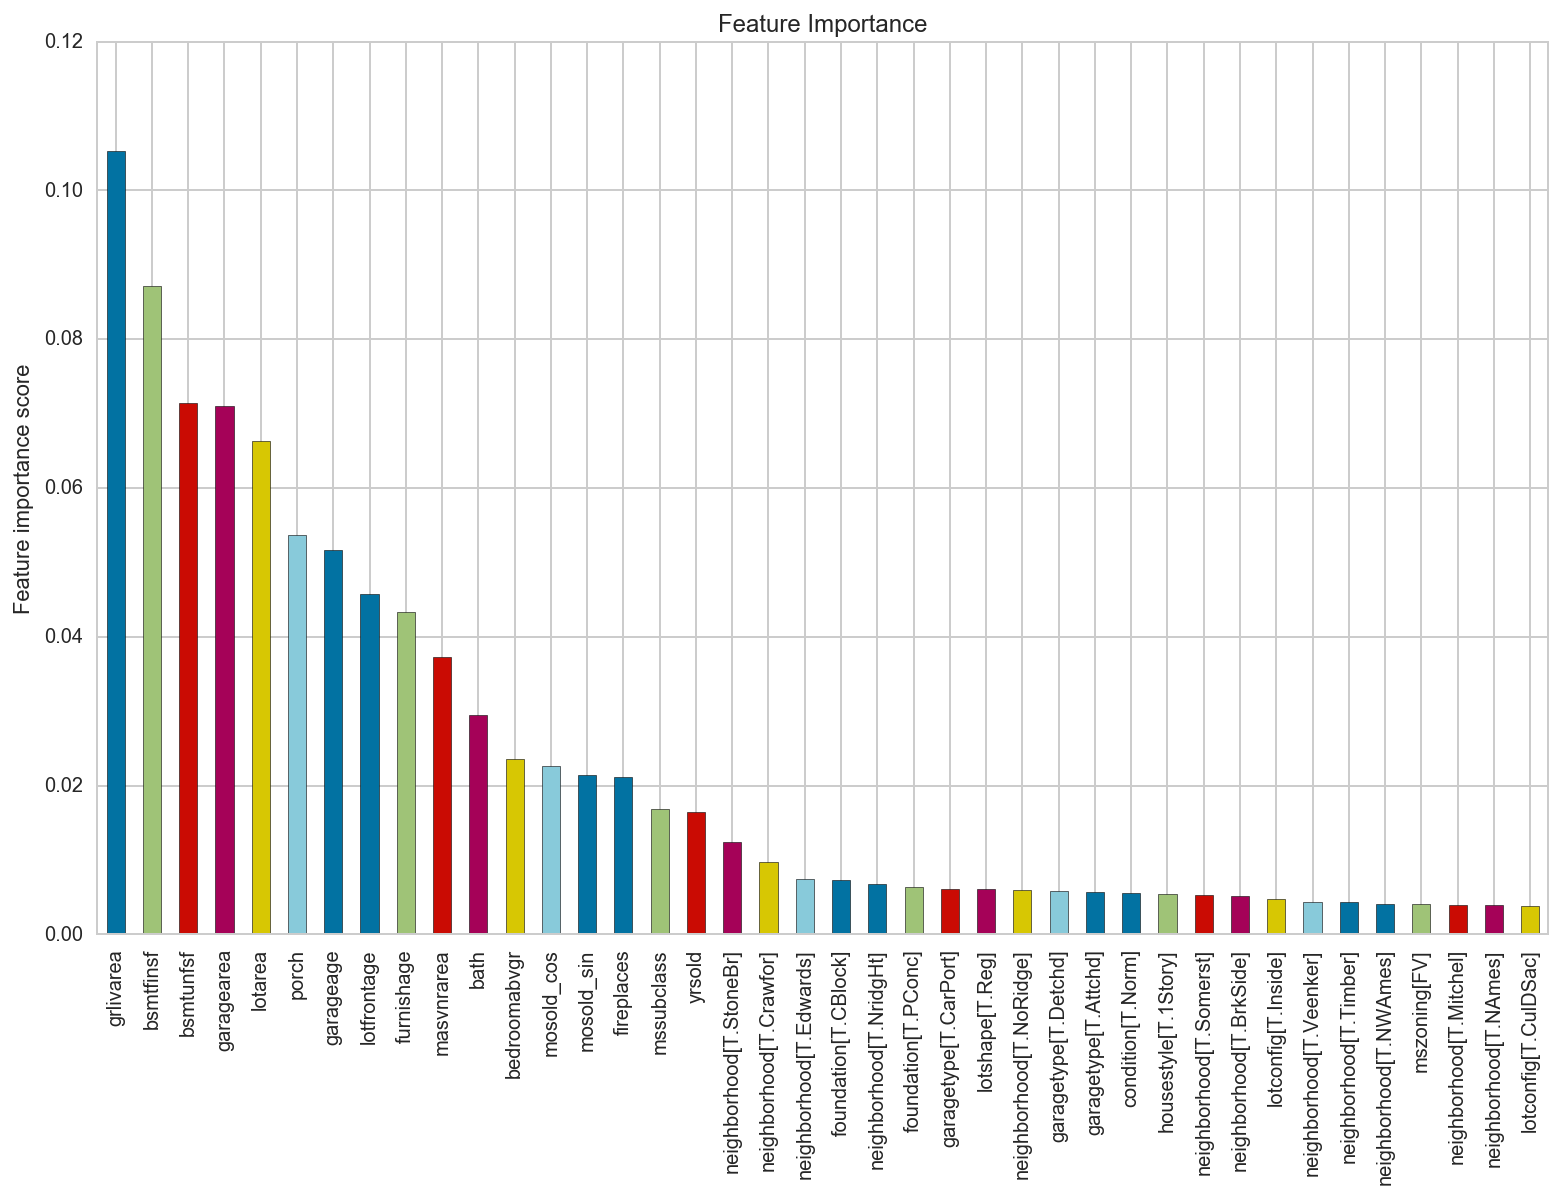

In [1064]:
gbr_best = GradientBoostingRegressor(max_depth=4, min_samples_split=10, min_samples_leaf = 2,max_features='sqrt', n_estimators=6400, subsample=0.85, learning_rate=0.005, random_state=123)
model(gbr_best, X_fixed_train, X_fixed_test, y_fixed_train, y_fixed_test)

> We can see that this provides us with the best accuracy score yet. The most important feature from this model is identified to be the area of the living area above ground. Let's look at a plot of the residuals to see if this model fulfils the assumption of the homodasceity of its errors.

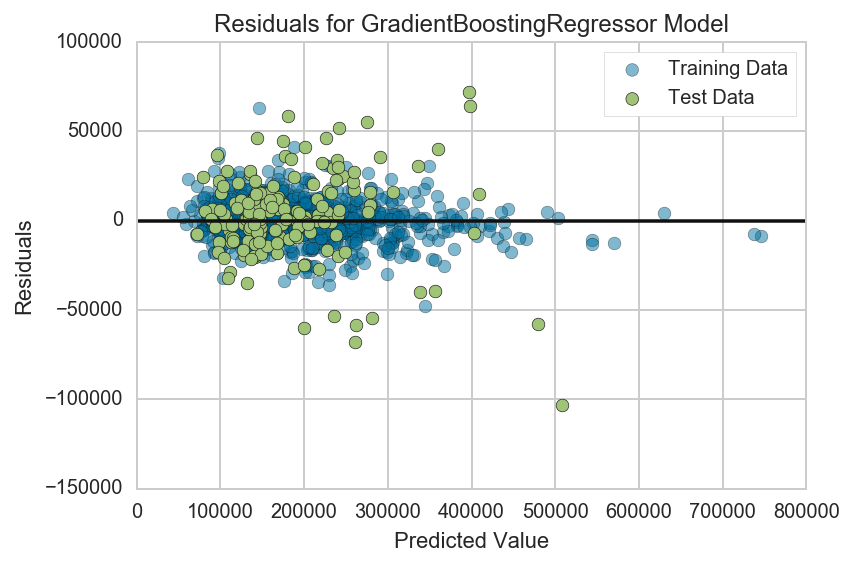

In [1068]:
from yellowbrick.regressor.residuals import ResidualsPlot
visualizer = ResidualsPlot(gbr_best)
visualizer.fit(Xs_fixed_train, y_fixed_train)
visualizer.score(Xs_fixed_test, y_fixed_test)
visualizer.poof()

> We can see that there does not seem to be a clear pattern forming that is characteristic of residuals with heterodasceity. Most values lie within +- 100,000, even for values that are on the higher end of the predicted vallues. There are a couple of points with high error values though that suggests the presence of outliers that can not be explained by the model.

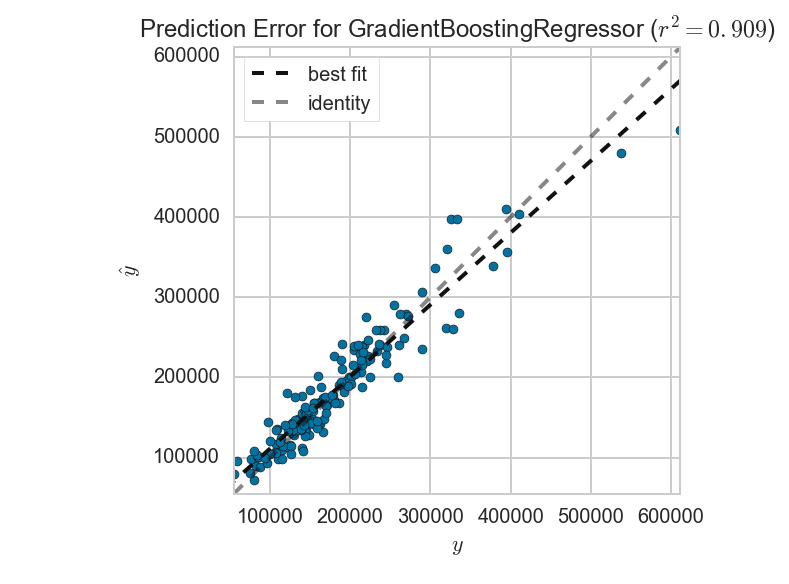

In [1067]:
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(gbr_best)

visualizer.fit(Xs_fixed_train, y_fixed_train)  
visualizer.score(Xs_fixed_test, y_fixed_test)  
visualizer.poof()


> The prediction error line with the best fit shows that our gradient boosted linear model was able to predict most of the saleprices in our test set. We will now look at how we might want to remove some outliers to improve our model even further.

### Outlier handling
>We look at our outliers at this point as we know what our most important feature is in predicting the saleprice. First we create a dataframe for all the fixed features including our saleprice. Doing so helped me realize that I needed to reset my index after dropping the 10 non-residential properties in part 1, which I have promptly gone back to edit.

In [1069]:
y_fixed_series = pd.Series(y_fixed, name='saleprice')
y_fixed_series.shape

(1450,)

In [1070]:
X_fixed.shape

(1450, 90)

In [1071]:
fixed = X_fixed.join(y_fixed_series)
fixed.shape

(1450, 91)

> We know that our most important feature is the living area above ground. Let's analyze it against the dependent variable to see if we can detect any outliers

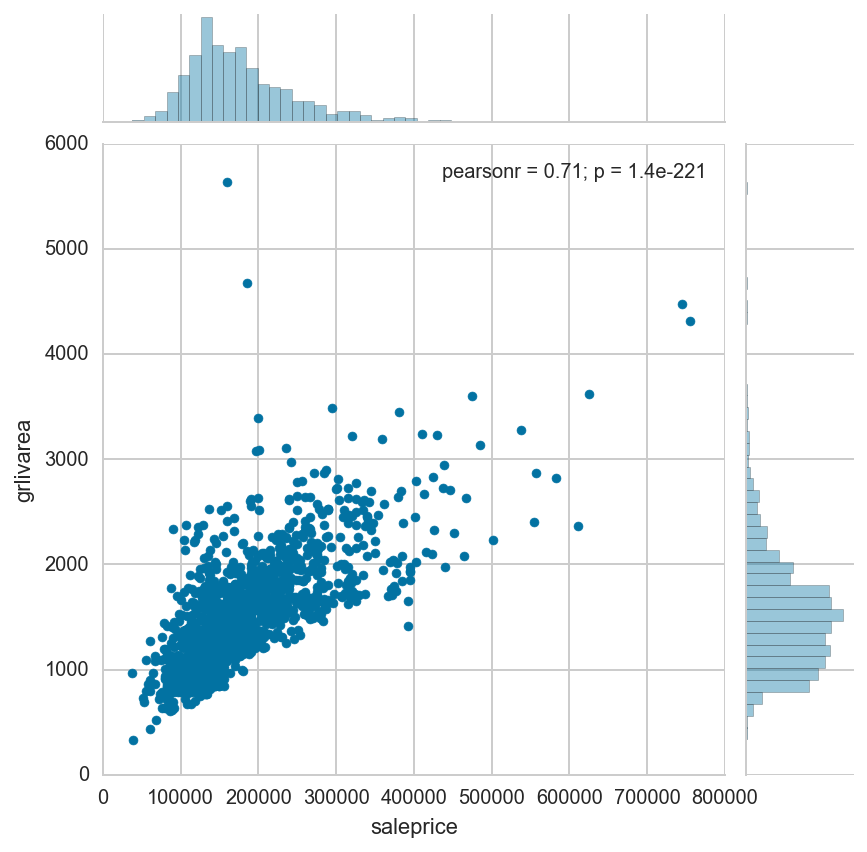

In [1072]:
sns.jointplot(fixed['saleprice'], fixed['grlivarea'])

> We can see that there is a strong correlation between grlivarea and the saleprice. There are however 2 properties that have large areas with saleprices that are too low for their size. We will attempt to drop them from our dataset and treat them as anomalies. 

In [1073]:
fixed.drop(index = fixed.loc[(fixed['grlivarea'] > 4000) & (fixed['saleprice'] < 200000)].index, inplace=True)

In [1074]:
fixed.shape

(1448, 91)

In [1075]:
X_fixed_out = fixed.iloc[:, :-1]
X_fixed_out.shape

(1448, 90)

In [1076]:
y_fixed_out = fixed['saleprice']
y_fixed_out.shape

(1448,)

In [1077]:
X_fixed_out_test = X_fixed_out.loc[fixed['yrsold'] == 2010, :]

In [1078]:
X_fixed_out_test.shape

(172, 90)

In [1079]:
X_fixed_out_train = X_fixed_out.loc[fixed['yrsold'] != 2010,:]

In [1080]:
X_fixed_out_train.shape

(1276, 90)

In [1081]:
y_fixed_out_test = y_fixed_out[fixed['yrsold'] == 2010]

In [1082]:
y_fixed_out_test.shape

(172,)

In [1083]:
y_fixed_out_train = y_fixed_out[fixed['yrsold'] != 2010]

In [1084]:
y_fixed_out_train.shape

(1276,)

> With our new training and test sets, let's model them against our tuned gradient boosted regressor.

Model Report:
RMSE:  21816.4924161
Accuracy:  0.925133009004


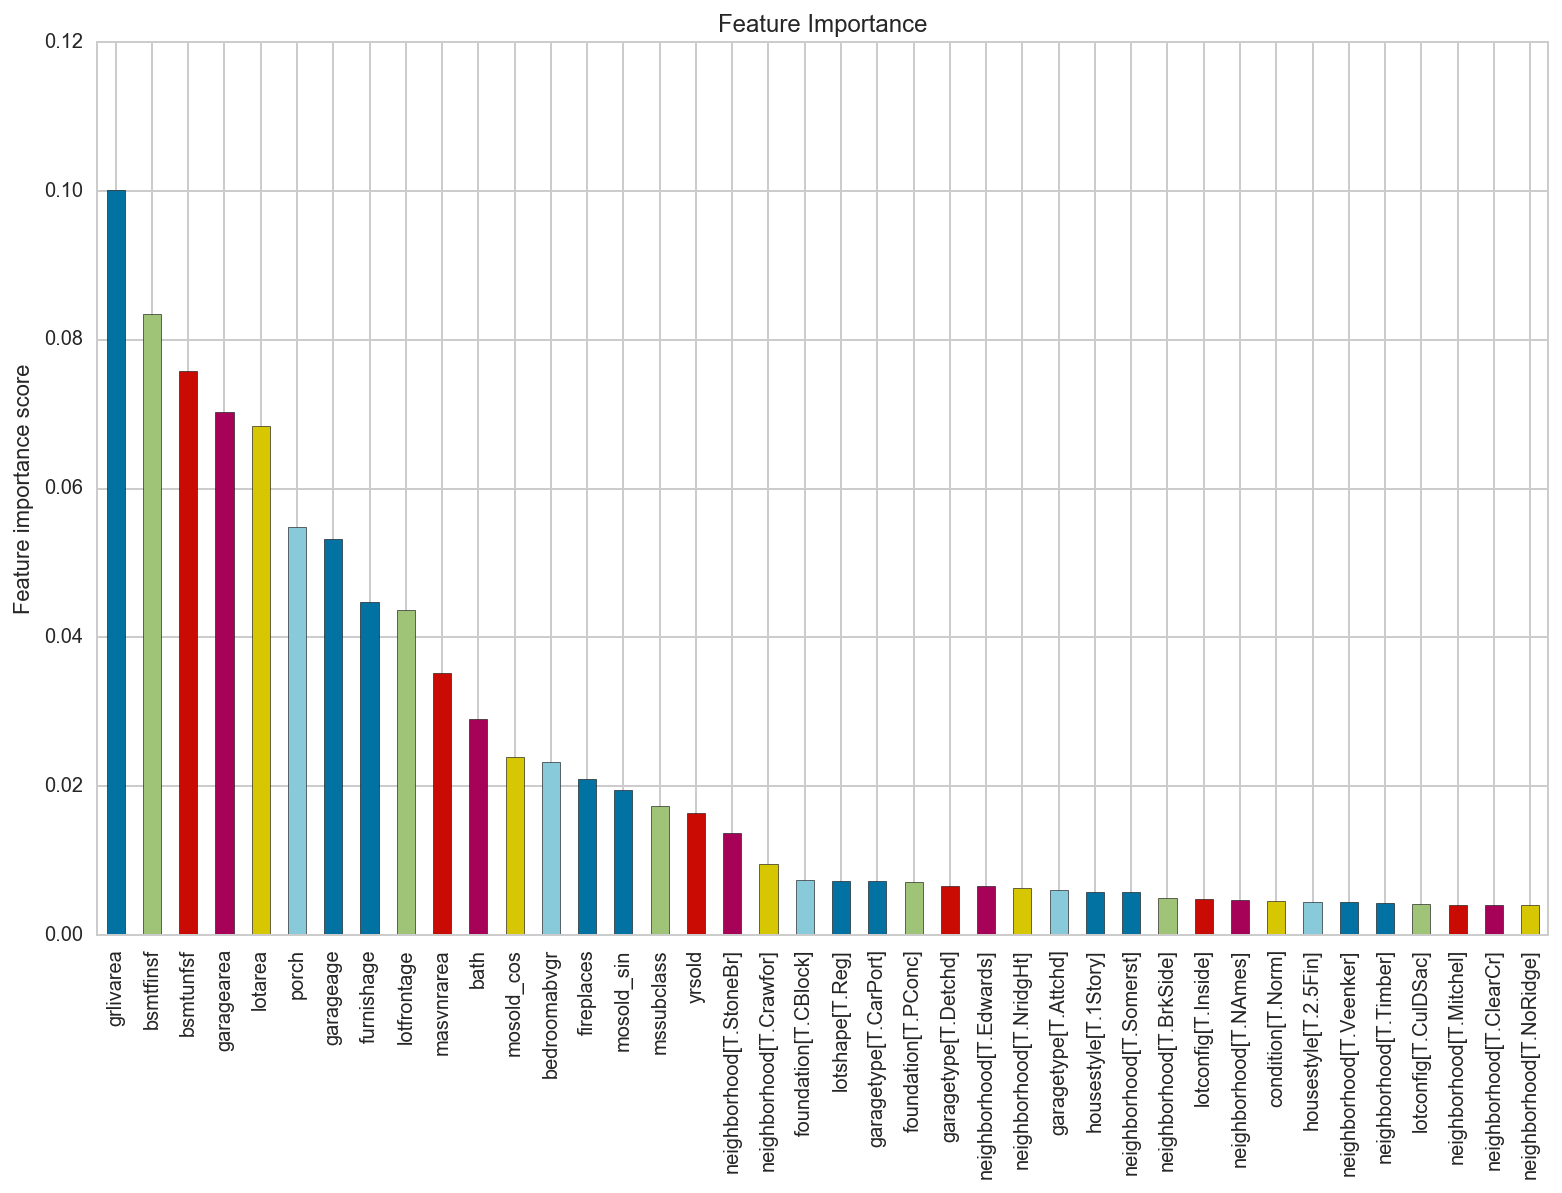

In [1115]:
model(gbr_best, X_fixed_out_train, X_fixed_out_test, y_fixed_out_train, y_fixed_out_test)

 > We can see that our accuracy has increased by 1.5%! The feature importance chart looks to not have changed from before the outlier removal. It seems that regardless of neighbourhood, the saleprice of a house is closely dependent on firstly, the area of the living area above ground, followed by the area of the basement, then the area of the surrounding vicinity including its garage, and porch. How old the garage is and when the house was furnished also features in contributing to the saleprice of a house.

> Let's take a look at the residuals and see how they compare against the previous plot

In [1086]:
Xs_fixed_out_train = ss.fit_transform(X_fixed_out_train)
Xs_fixed_out_test = ss.fit_transform(X_fixed_out_test)
print Xs_fixed_out_train.shape, Xs_fixed_out_test.shape

(1276, 90) (172, 90)


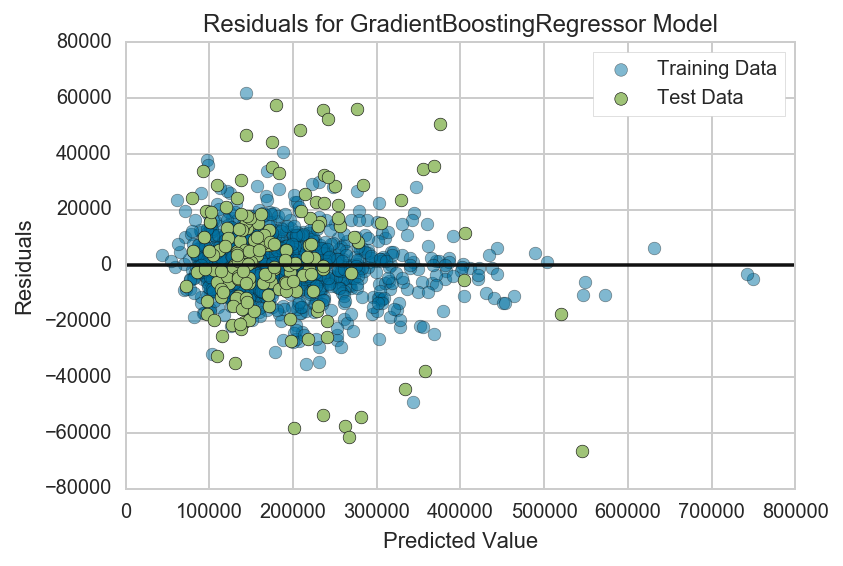

In [1087]:
from yellowbrick.regressor.residuals import ResidualsPlot
visualizer = ResidualsPlot(gbr_best)
visualizer.fit(Xs_fixed_out_train, y_fixed_out_train)
visualizer.score(Xs_fixed_out_test, y_fixed_out_test)
visualizer.poof()

> The first thing we should notice is that the range of our residuals has shrunk to be bounded between +-70,000. The 2 outliers were contributing to quite a substantial amount of uncertainty in our model. Much like the plot before, we do not notice any noticeable pattern here which does not violate our assumption of homodasceitic errors in our model.

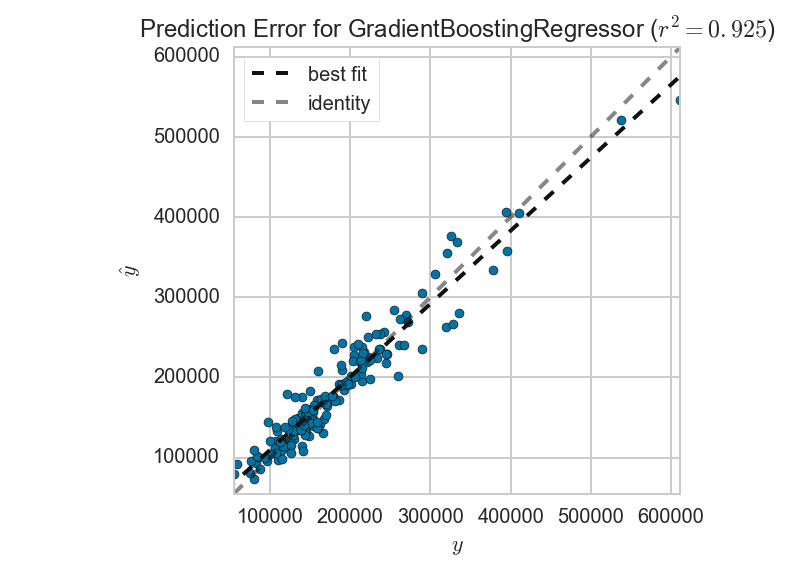

In [1088]:
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(gbr_best)

visualizer.fit(Xs_fixed_out_train, y_fixed_out_train)  
visualizer.score(Xs_fixed_out_test, y_fixed_out_test)  
visualizer.poof()

> Finally, our best fit line looks to be even closer to the ideal fit line, suggesting that our model has a high degree of accuracy.

### Model comparison and selection

Model | R<sup>2</sup> score
--- | ---
Linear Regression | -2.3405
Ridge Regression | 0.8499
Lasso Regression | 0.8515
ElasticNet | 0.8515
SGD Regressor | 0.8360
Gradient Boosted Regressor | 0.9090
Gradient Boosted Regressor w/o outliers | 0.9251



> Judging by the R<sup>2</sup> values alone, we will use the Gradient Boosted Regressor as our model of choice in predicting future prices of houses. We have to keep in mind that this model was developed solely on the fixed features of the house. 

> We have seen that the main criteria to look for in estimating the saleprice of a house in Ames is its living area above ground. Other area-related features like porch and basement square feet can and should be taken into consideration too.

> This is only half the story however. We want to also investigate how much more the renovatable features contribute to the saleprice of a house and which are the most cost-efficient renovations that we can do to derive the most value. This will be covered in the next section.